# imports

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys, os, time
sys.path.append('/mnt/home/cmodi/.local/lib/python3.8/site-packages/')


In [3]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [4]:
import sbi
import torch
import wandb
from wandb import Api
import zeus
import emcee

from arviz import rhat, ess, autocorr


/mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


ModuleNotFoundError: No module named 'zeus'

In [ ]:
sys.path.append('../src/')

import loader_pk
import sbitools, sbiplots
%pylab inline

In [ ]:
cosmonames = sbitools.quijote_params()[-1] + ['$c_s$']
args = {"kmin": 0.001, "kmax":0.5, "offset_amp":0, "ampnorm":False, "alg":"snpe"}
args = sbitools.Objectify(args)
kcut, features, params = loader_pk.loader(args, return_k=True)

# testidx = np.load('/mnt/ceph/users/cmodi/HySBI/test-train-splits/test-N2000-f0.15-S0.npy')
testidx = np.load('../data/testidx_p0-0.15-0.45_p4-0.65-0.95.npy')
testidx;

In [ ]:
bounds = [params.min(axis=0), params.max(axis=0)]
print(bounds)
goodids = []
for pid in testidx:
    p = params[pid]
    good = True
    for j in range(5):
        r = bounds[1][j] - bounds[0][j] 
        if (bounds[0][j] + 0.25*r < p[j] < bounds[1][j] - 0.25*r):
            pass
        else:
            good = False
    if good:
        print(pid, p)
        goodids.append(pid)


# SNPE with matter spectra

In [ ]:
# a, b, c, 
# y = ax**2 + bx + c + noise 
# noise = random(0, 0.01
# x [ 0, 10]

In [ ]:
features = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/s1_M4_J7_Q4_e0.1_kc0.67.npy')
features0 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/s0_M4_J7_Q4_e0.1_kc0.67.npy')
# features = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/s1_M4_J7_Q2_e0.1_kc1.0.npy')
features.shape, features0.shape

In [ ]:
features_split = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/s1_M4_J7_Q4_e0.1_kc0.67_split2.npy').mean(axis=1)
features0_split = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/s0_M4_J7_Q4_e0.1_kc0.67_split2.npy').mean(axis=1)


In [ ]:
# trainx, scaler = sbitools.standardize(features, secondary=None, log_transform=False)
trainx = features[:, :, :3].reshape(2000, -1).copy()
trainx = np.concatenate([features0, trainx], axis=1)
trainx, scaler = sbitools.standardize(trainx, secondary=None, log_transform=True)
trainy = params.copy()
trainx.shape, trainy.shape

In [ ]:
test_split = np.concatenate([features0_split, features_split[:, :, :3].reshape(2000, -1)], axis=1)
test_split = sbitools.standardize(test_split.copy(), secondary=None, log_transform=True, scaler=scaler)[0]


In [ ]:
### SBI
# trainx, scaler = sbitools.standardize(features, secondary=None, log_transform=True)
# trainy = params.copy()
prior = sbitools.sbi_prior(params.reshape(-1, params.shape[-1]), offset=0.2)
posterior, inference, summary = sbitools.sbi(trainx, trainy, prior, \
                                            summarize=True,
                                            verbose=True, nhidden=64, 
                                             nlayers=10, alg='snpe')

In [ ]:
i = 3
fig, ax = sbiplots.plot_posterior(trainx[i], trainy[i], posterior)

In [ ]:
nsims, nsamples = 100, 1000
samples = np.zeros([nsims, nsamples, params.shape[1]])
for j in range(100):
    x = trainx[j].copy()
    samples[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()

    

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for j in range(5):
    # plt.plot(params[:nsims, j], params[:nsims, j], 'k.')
    ax[j].plot([params[:nsims, j].min(), params[:nsims, j].max()], [params[:nsims, j].min(), params[:nsims, j].max()], 'k')
    ax[j].errorbar(params[:nsims, j], samples.mean(axis=1)[:, j], samples.std(axis=1)[:, j], fmt='.')
    ax[j].set_xlabel(cosmonames[j])

In [ ]:
nsims, nsamples = 100, 1000
samples2 = np.zeros([nsims, nsamples, params.shape[1]])
for j in range(100):
    x = test_split[j].copy()
    samples2[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()


In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for j in range(5):
    # plt.plot(params[:nsims, j], params[:nsims, j], 'k.')
    ax[j].plot([params[:nsims, j].min(), params[:nsims, j].max()], [params[:nsims, j].min(), params[:nsims, j].max()], 'k')
    ax[j].errorbar(params[:nsims, j], samples.mean(axis=1)[:, j], samples.std(axis=1)[:, j], fmt='.')
    ax[j].errorbar(params[:nsims, j], samples2.mean(axis=1)[:, j], samples2.std(axis=1)[:, j], fmt='.')
    ax[j].set_xlabel(cosmonames[j])


# SNLE with matter spectra

In [ ]:
from sbi.inference import SNLE_A
from sbi.utils.get_nn_models import posterior_nn, likelihood_nn


In [ ]:
args = {"kmin": 0.001, "kmax":0.5, "offset_amp":0, "ampnorm":False}
args = sbitools.Objectify(args)
kcut, features, params = loader_pk.loader(args, return_k=True)
trainx, scaler = sbitools.standardize(features, secondary=None, log_transform=True)
trainy = params.copy()


In [ ]:
sbi.utils.BoxUniform()

In [ ]:
prior = sbitools.sbi_prior(params.reshape(-1, params.shape[-1]), offset=0.2, device='cpu')
density_estimator_build_fun = likelihood_nn(model='maf', \
                                           hidden_features=32, \
                                           num_transforms=8,
                                           num_blocks=2)

inference = SNLE_A(prior=prior, density_estimator=density_estimator_build_fun, device='cpu')
inference.append_simulations(x= torch.from_numpy(trainx.astype('float32')), 
                            theta= torch.from_numpy(trainy.astype('float32')))

density_estimator = inference.train(training_batch_size=16,
                                        validation_fraction=0.1,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

posterior_nle = inference.build_posterior(density_estimator)



In [ ]:
# j = 0 
# nsamples = 500 
# x = trainx[j].copy()
# samples_nle = posterior_nle.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=True).detach().numpy()


In [124]:

from sbi.inference import likelihood_estimator_based_potential
potential_fn, parameter_transform = likelihood_estimator_based_potential(
                                                                        density_estimator, 
                                                                        prior, 
                                                                        torch.from_numpy(trainx[0].reshape(1, -1).astype(np.float32)))

def log_prob(x):
    return potential_fn(torch.from_numpy(x.reshape(1, -1).astype(np.float32))).detach().numpy()[0]
    # loglik =  density_estimator.log_prob(torch.from_numpy(y.reshape(1, -1).astype(np.float32)), context=torch.from_numpy(x.reshape(1, -1).astype(np.float32))).detach().numpy()[0]
    # logprior = prior.log_prob(torch.from_numpy(trainy[0].reshape(1, -1).astype(np.float32))).detach().numpy()[0]
    # return loglik + logprior
    
data = trainx[0].copy()
nsteps, nwalkers, ndim = 100, 20, 5
x0 = np.stack([trainy[np.random.randint(0, trainy.shape[0])] for _ in range(nwalkers)])
print(log_prob(trainy[0]))

# start = time.time()
# sampler = zeus.EnsembleSampler(nwalkers, ndim, log_prob)
# sampler.run_mcmc(x0, nsteps, progress=True)
# chain = sampler.get_chain(flat=False, discard=0.2);
# print("Time taken = ", time.time() - start)


start = time.time()
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(x0, nsteps, progress=True)
chain = sampler.get_chain(flat=False, discard=int(0.2*nsteps));
print("Time taken = ", time.time() - start)

164.83936


100%|██████████| 100/100 [00:05<00:00, 18.30it/s]

Time taken =  5.525553464889526


In [133]:
parameter_transform(torch.from_numpy(x0.reshape(1, -1).astype(np.float32)))

RuntimeError: The size of tensor a (100) must match the size of tensor b (5) at non-singleton dimension 1

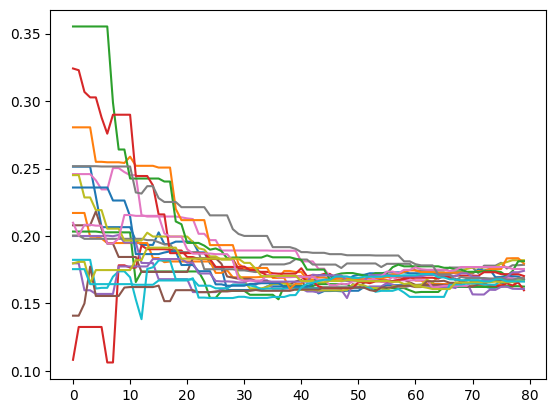

In [127]:
plt.plot(chain[..., 0])

In [ ]:
# from sbi.inference import likelihood_estimator_based_potential
# potential_fn, parameter_transform = likelihood_estimator_based_potential(
#                                                                         density_estimator, 
#                                                                         prior, 
#                                                                         torch.from_numpy(trainx[0].reshape(1, -1).astype(np.float32)))
# def log_prob(x):
#     return potential_fn(torch.from_numpy(x.reshape(1, -1).astype(np.float32)).to('cuda')).cpu().detach().numpy()[0]
    
# data = trainx[0].copy()
# nsteps, nwalkers, ndim = 500, 20, 5
# x0 = np.stack([trainy[np.random.randint(0, trainy.shape[0])] for _ in range(nwalkers)])
# print(log_prob(trainy[0]))


# start = time.time()
# sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
# sampler2.run_mcmc(x0, nsteps, progress=True)
# chain2 = sampler2.get_chain(flat=False, discard=int(0.2*nsteps));
# print("Time taken = ", time.time() - start)

In [ ]:
from sbi.inference import likelihood_estimator_based_potential
potential_fn2, parameter_transform2 = likelihood_estimator_based_potential(
                                                                        density_estimator2, 
                                                                        prior, 
                                                                        torch.from_numpy(trainx[0].reshape(1, -1).astype(np.float32)))
def log_prob2(x):
    return potential_fn2(torch.from_numpy(x.reshape(1, -1).astype(np.float32)).to('cuda')).cpu().detach().numpy()[0]
    
data = trainx[0].copy()
# x = trainy[99].copy()
nsteps, nwalkers, ndim = 500, 20, 5
x0 = np.stack([trainy[np.random.randint(0, trainy.shape[0])] for _ in range(nwalkers)])
print(log_prob(trainy[0]))

start = time.time()
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob2)
sampler2.run_mcmc(x0, nsteps, progress=True)
chain2 = sampler2.get_chain(flat=False, discard=int(0.2*nsteps));
print("Time taken = ", time.time() - start)

In [ ]:
%timeit log_prob(x0[0])

In [ ]:
%timeit log_prob2(x0[0])

In [ ]:
# from sbi.inference import MCMCPosterior, RejectionPosterior

# posterior1 = MCMCPosterior(potential_fn, proposal=prior, theta_transform=parameter_transform)
# posterior2 = RejectionPosterior(potential_fn, proposal=prior)



In [ ]:
# samples1 = posterior1.sample((100,))
# samples2 = posterior2.sample((100,))

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

for i in range(5):
    ax[i].plot(samples_nle[:, i])
    ax[i].grid(which='both')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

for i in range(5):
    ax[i].plot(chain[:, 0, i])
    ax[i].plot(chain2[:, 0, i])
    ax[i].grid(which='both')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

j = 0 
for i in range(5):
    ax[i].hist(samples[j][:, i], density=True, bins='auto')
    ax[i].hist(samples_nle[:, i], alpha=0.5, density=True, bins='auto')
    ax[i].hist(chain[..., i].flatten(), alpha=0.5, density=True, bins='auto')
    ax[i].hist(chain2[..., i].flatten(), alpha=0.5, density=True, bins='auto')
    ax[i].axvline(params[j, i], color='k')
    ax[i].grid(which='both')
    ax[i].set_xlim(params.min(axis=0)[i], params.max(axis=0)[i])
ax[i].seet_xlim(0.65, 0.7)
plt.tight_layout()

In [ ]:
# sbiplots.plot_posterior(trainx[j].copy(), trainy[j].copy(), posterior_nle)

#  Sub boxes

In [183]:
psubs = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/power_split4.npy')
ksub  = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split4.npy')
# p2 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/power_split4.npy').real
# k1 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split2.npy')
idx = (ksub > 0.15) & (ksub < 0.5)
ksub = ksub[idx]
psubs = psubs[..., idx]
print(ksub.shape, psubs.shape)

(56,) (2000, 64, 56)


In [184]:
### SBI
trainxsub, scalersub = sbitools.standardize(psubs[:, 0, :], secondary=None, log_transform=True)
trainysub = params.copy()
priorsub = sbitools.sbi_prior(params.reshape(-1, params.shape[-1]), offset=0.2)
posteriorsub, inferencesub, summarysub = sbitools.sbi(trainxsub, trainysub, priorsub, \
                                            summarize=True,
                                            verbose=True, 
                                             nlayers=8, alg='snpe')

Training a new NF
With algorithm SNPE
 Neural network successfully converged after 118 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 118
        Best validation performance: 8.4893
        -------------------------
        


In [ ]:
# i = 3
# fig, ax = sbiplots.plot_posterior(trainx[i], trainy[i], posterior)
# fig, ax = sbiplots.plot_posterior(trainxsub[i], trainysub[i], posteriorsub)

nsims, nsamples = 300, 1000
samples = np.zeros([nsims, nsamples, params.shape[1]])
samplessub = np.zeros([nsims, nsamples, params.shape[1]])
for j in range(nsims):
    if j%20 ==0 : print(j)
    x = trainx[j].copy()
    samples[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()
    x = trainxsub[j].copy()
    samplessub[j] = posteriorsub.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()

    

In [ ]:
isim = 5 

fig, ax = plt.subplots(1, 5, figsize=(18, 4))

j = 0 
for i in range(5):
    ax[i].hist(samples[isim][:, i], density=True, bins='auto')
    ax[i].hist(samplessub[isim][:, i], density=True, bins='auto', alpha=0.7)
    ax[i].axvline(params[isim, i], color='k')


In [ ]:
isim = 5 

fig, ax = plt.subplots(1, 5, figsize=(25, 6))

j = 0 
skip = 2
for i in range(5):
    # ax[i].errorbar(params[:100:skip, i], samples[::skip,:, i].mean(axis=1), samples[::skip,:, i].std(axis=1), fmt='.', alpha=0.7, elinewidth=0.7)
    # ax[i].errorbar(params[:100:skip, i]*1.01, samplessub[::skip,:, i].mean(axis=1), samplessub[::skip,:, i].std(axis=1), fmt='.', alpha=0.7, elinewidth=0.7)
    # ax[i].plot([params[..., i].min(), params[..., i].max()], [params[..., i].min(), params[..., i].max()], 'k')
    
    ax[i].errorbar(params[:nsims:skip, i], samples[::skip,:, i].mean(axis=1)-params[:nsims:skip, i], 
                   samples[::skip,:, i].std(axis=1), fmt='.', alpha=0.7, elinewidth=0.9)
    ax[i].errorbar(params[:nsims:skip, i]*1.01, samplessub[::skip,:, i].mean(axis=1)-params[:nsims:skip, i],
                   samplessub[::skip,:, i].std(axis=1), fmt='.', alpha=0.7, elinewidth=0.9)
    ax[i].axhline(0., color='k', lw=0.5)
    ax[i].grid(which='both')

In [ ]:
skip = 1
bias = (samples[::skip,:, i].mean(axis=1)-params[:nsims:skip, i])/samples[::skip,:, i].std(axis=1)
plt.hist(bias, bins='auto', density=True)
bias = (samplessub[::skip,:, i].mean(axis=1)-params[:nsims:skip, i])/samplessub[::skip,:, i].std(axis=1)
plt.hist(bias, alpha=0.5, bins='auto', density=True)

# skip = 1
# bias = (samples[::skip,:, i].mean(axis=1)-params[:nsims:skip, i]) #/samples[::skip,:, i].std(axis=1)
# plt.hist(bias, bins='auto', density=True)
# bias = (samplessub[::skip,:, i].mean(axis=1)-params[:nsims:skip, i]) #/samplessub[::skip,:, i].std(axis=1)
# plt.hist(bias, alpha=0.5, bins='auto', density=True);


# hybrid

In [ ]:
psubs = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/power_split4.npy')
ksub  = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split4.npy')
# p2 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/power_split4.npy').real
# k1 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split2.npy')
idx = (ksub > 0.15) & (ksub < 0.5)
ksub = ksub[idx]
psubs = psubs[..., idx]
print(ksub.shape, psubs.shape)

trainxhy, scalerhy = sbitools.standardize(psubs[:, 0, :], secondary=None, log_transform=True)


In [ ]:
pfull = np.load('/mnt/home/cmodi/Research/Projects/HySBI/data/pkmatter_quijote.npy')[:, 1:]
kfull, pfull = pfull[0, :, 0], pfull[..., 1]
idx = (kfull <= 0.15)
kfull = kfull[idx]
pfull = pfull[:, idx]
pkcond, scaler_pkcond = sbitools.standardize(pfull, secondary=None, log_transform=True)

trainyhy = np.concatenate([params, pkcond], axis=-1)


In [ ]:
trainyhy.shape

In [ ]:
# ### SBI
# priorhy = sbitools.sbi_prior(params.reshape(-1, params.shape[-1]), offset=0.2)
# posteriorhy, inferencehy, summaryhy = sbitools.sbi(trainxhy, trainyhy, priorhy, \
#                                             summarize=True,
#                                             verbose=True, 
#                                              nlayers=8, alg='snpe')


priorhy = sbitools.sbi_prior(trainyhy, offset=0.2, device='cpu')
density_estimator_build_fun = likelihood_nn(model='maf', \
                                           hidden_features=32, \
                                           num_transforms=8,
                                           num_blocks=2)

inference_nle = SNLE_A(prior=prior, density_estimator=density_estimator_build_fun, device='cpu')
inference_nle.append_simulations(x= torch.from_numpy(trainxhy.astype('float32')), 
                            theta= torch.from_numpy(trainyhy.astype('float32')))

density_estimator_nle = inference_nle.train(training_batch_size=32,
                                        validation_fraction=0.1,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

posterior_nle = inference_nle.build_posterior(density_estimator_nle)



In [ ]:
# i = 3
# fig, ax = sbiplots.plot_posterior(trainx[i], trainy[i], posterior)
# fig, ax = sbiplots.plot_posterior(trainxsub[i], trainysub[i], posteriorsub)

nsims, nsamples = 300, 1000
sampleshy = np.zeros([nsims, nsamples, params.shape[1]])
for j in range(nsims):
    if j%20 ==0 : print(j)
    x = trainxhy[j].copy()
    sampleshy[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()
    
    

# ensemble

In [16]:
from sbi.utils.posterior_ensemble import NeuralPosteriorEnsemble
import yaml
api = wandb.Api()


In [17]:

def insert_sweep_name(path):
    if '%s' in path:
        dirname = '/'.join(cfg_path.split('/')[:-2])
    else:
        dirname = path
    print(f"In directory {dirname}")
    for root, dirs, files in os.walk(dirname):
        if len(dirs) > 1 :
            print('More than 1 sweeps, abort!')
            raise
        break
    print(f"Sweep found : {dirs[0]}")
    if '%s' in path:
        return path%dirs[0]
    else:
        return path + f'/{dirs[0]}/'


def setup_cfg(cfg_path, verbose=False):

    cfg_path = insert_sweep_name(cfg_path)
    # print(cfg_path)
    cfg_dict = yaml.load(open(f'{cfg_path}/sweep_config.yaml'), Loader=yaml.Loader)
    sweep_id = cfg_dict['sweep']['id']
    sweep = api.sweep(f'modichirag92/hysbi/{sweep_id}')
    #sort in the order of validation log prob
    names, log_prob = [], []
    for run in sweep.runs:
        if run.state == 'finished':
            # print(run.name, run.summary['best_validation_log_prob'])
            try:
                model_path = run.summary['output_directory']
                names.append(run.name)
                log_prob.append(run.summary['best_validation_log_prob'])
            except Exception as e:
                print('Exception in checking state of run : ', e)
    idx = np.argsort(log_prob)[::-1]
    names = np.array(names)[idx]

    args = {}
    for i in cfg_dict.keys():
        args.update(**cfg_dict[i])
    cfg = sbitools.Objectify(**args)
    cfg.analysis_path = loader_pk.folder_path(cfg_dict, verbose=verbose)
    scaler = sbitools.load_scaler(cfg.analysis_path)

    toret = {'sweepid':sweep_id, 'cfg':cfg, 'idx':idx, 'scaler':scaler, 'names':names, 'cfg_dict':cfg_dict}
    return toret


cfg_p = '/mnt/ceph/users/cmodi/HySBI/matter/snpe/kmax0.5-kmin0.001-logit-offset_amp10000.0-standardize/'
cfg_p = setup_cfg(cfg_p)
cfg_l = '/mnt/ceph/users/cmodi/HySBI/matter/snle/kmax0.5-kmin0.001-logit-standardize//'
cfg_l = setup_cfg(cfg_l)

In directory /mnt/ceph/users/cmodi/HySBI/matter/snpe/kmax0.5-kmin0.001-logit-offset_amp10000.0-standardize/


UnboundLocalError: local variable 'dirs' referenced before assignment

In [ ]:
features_p, params_p = loader_pk.loader(cfg_p['cfg'])
features_l, params_l = loader_pk.loader(cfg_l['cfg'])

In [ ]:
def get_samples(features, sweepdict, standardize=True, nposterior=1, nsamples=1000, cosmoonly=True, verbose=False):
    sweepid = sweepdict['sweepid']
    if standardize:
        if len(features.shape) == 1: features = features.reshape(1, -1)
        features = sbitools.standardize(features, scaler=sweepdict['scaler'], log_transform=sweepdict['cfg'].logit)[0]
    
    posteriors = []
    for j in range(nposterior):
        name = sweepdict['names'][j]
        if verbose: print(name)
        model_path = f"{sweepdict['cfg'].analysis_path}/{sweepid}/{name}/"
        posteriors.append(sbitools.load_posterior(model_path))
    posterior = NeuralPosteriorEnsemble(posteriors=posteriors)
    samples = posterior.sample((nsamples,), x=torch.from_numpy(features.astype('float32')), show_progress_bars=verbose).detach().numpy()
    if cosmoonly: return np.array(samples)[:, :5]
    else: return np.array(samples)


isim = 0
samples_p = get_samples(features_p[isim], cfg_p, nposterior=5)
# samples_l = get_samples(features_l[isim], cfg_l, nposterior=5)

In [ ]:
# samples_l = get_samples(features_l[isim], cfg_l, nposterior=5, verbose=True)
samples_l2 = get_samples(features_l[isim], cfg_l, nposterior=1, verbose=False, nsamples=100)

In [ ]:
idim = 0 
plt.hist(samples_p[:, idim], density=True)
plt.hist(samples_l[:, idim], density=True)
plt.axvline(params_p[isim, idim], color='k')
plt.show()
idim = 4 
plt.hist(samples_p[:, idim], density=True)
plt.hist(samples_l[:, idim], density=True)
plt.axvline(params_p[isim, idim], color='k')

In [ ]:
idim = 4
plt.plot(samples_l[:200, idim])

In [ ]:
def ensemble_logprob_snle(features, sweepdict, standardize=True, nposterior=1, track_gradients=False, batch=2):
    sweepid = sweepdict['sweepid']
    if standardize:
        if len(features.shape) == 1: features = features.reshape(1, -1)
        features = sbitools.standardize(features, scaler=sweepdict['scaler'], log_transform=sweepdict['cfg'].logit)[0]
    
    posteriors = []
    for j in range(nposterior):
        name = sweepdict['names'][j]
        model_path = f"{sweepdict['cfg'].analysis_path}/{sweepid}/{name}/"
        posteriors.append(sbitools.load_posterior(model_path))

    # x = torch.from_numpy(features.reshape(1, -1).astype(np.float32))
    features = np.array([features]*batch).reshape(batch, features.shape[-1])
    x = torch.from_numpy(features.astype(np.float32))
    print(x.shape)
    
    def log_prob(theta, x):
        # theta = torch.from_numpy(theta.reshape(batch, -1).astype(np.float32))#.to('cuda')
        batch = theta.shape[0]
        theta = torch.from_numpy(theta.astype(np.float32))
        x = np.array([x]*batch).reshape(batch, x.shape[-1])
        x = torch.from_numpy(x.astype(np.float32))

        lp = 0.        
        
        for p in posteriors:
            lp += p.potential_fn.likelihood_estimator.log_prob(x, theta).detach().numpy()
        lp /= len(posteriors)
        
        lp += posteriors[0].potential_fn.prior.log_prob(theta).detach().numpy()
        return lp
    
    
    return log_prob


In [ ]:
# p.potential_fn.likelihood_estimator.log_prob(x, theta).detach().numpy()

In [ ]:
isim = 0
lp_ens = ensemble_logprob_snle(features_l[isim], cfg_l, nposterior=5, batch=1)
lp_ens(params[np.random.randint(0, 2000, 4)], features[0])

%timeit lp_ens(params[np.random.randint(0, 2000)], features[0])

In [ ]:
isim = 0
batch = 16
lp_ens = ensemble_logprob_snle(features_l[isim], cfg_l, nposterior=5, batch=batch)
lp_ens(params[np.random.randint(0, 2000, batch)], features[0])

%timeit lp_ens(params[np.random.randint(0, 2000, batch)], features[0])

## emcee it

In [ ]:
nsteps, nwalkers, ndim = 100, 2*batch, 5
burn_in = 10 
thin = 1
x0 = params[:nwalkers]
start = time.time()
print('emcee it')
sampler = emcee.EnsembleSampler(nwalkers, ndim, lp_ens, vectorize=True, args=(features[0],))
sampler.run_mcmc(x0, nsteps + burn_in, progress=True)
chain = sampler.get_chain(flat=False, discard=burn_in, thin=thin)
print("Time taken : ", time.time()-start)


In [ ]:
snpe_samples = posterior.sample((1000,), x=torch.from_numpy(trainx[0].astype('float32')), show_progress_bars=False).detach().numpy()


In [ ]:
idim = 4 
plt.hist(chain[..., idim].flatten(), bins='auto', density=True);
plt.hist(samples_l[..., idim].flatten(), bins='auto', alpha=0.5, density=True);
# plt.hist(samples_p[..., idim].flatten(), bins='auto', alpha=0.5);
plt.hist(snpe_samples[..., idim].flatten(), bins='auto', alpha=0.5, density=True);
# plt.hist(samples_l2[..., idim].flatten(), bins='auto');


In [ ]:
plt.plot(chain[100:, 0, idim])
plt.plot(chain[100:, 2, idim])

# plot runs


In [13]:

def corner(samples, truevals=None, savepath="./tmp/", savename=None, save=True, maxdims=10, titles=None):
    '''Make corner plot for the distribution from samples                                                                                                                                                                                                                                                                     
    '''
    D = samples.shape[-1]
    D = min(D, maxdims)
    if titles is None:
        titles = [f'W[{i}]' for i in range(D)]
    fig, ax = plt.subplots(D, D, figsize=(3*D, 2*D), sharex='col')
    for i in range(D):
        for j in range(D):
            if i==j:
                ax[i, j].hist(samples[:, i])
                ax[i, j].set_title(titles[i])
                if truevals is not None:
                    ax[i, i].axvline(truevals[i], color='k', lw=0.5)
            elif i>j:
                ax[i, j].plot(samples[:, j], samples[:, i], '.')
                if truevals is not None:
                    ax[i, j].axhline(truevals[i], color='k', lw=0.5)
                    ax[i, j].axvline(truevals[j], color='k', lw=0.5)
            else:
                ax[i, j].axis('off')

    for i in range(D):
        ax[i, i].set_title(titles[i])

    plt.tight_layout()
    return fig, ax




In [22]:
# def autocorr(chain) :
#     """Return sample autocorrelations at all lags from 0 to the length
#     of the sequence minus 1 for the specified sequence.  The returned
#     vector will thus be the same size as the input vector.

#     Algorithmically, this function calls NumPy's fast Fourier transform
#     and inverse fast Fourier transforms.

#     Parameters:
#         chain: sequence whose autocorrelation is returned

#     Returns:
#         autocorrelation estimates at all lags for the specified sequence

#     Raises:
#         ValueError: if the size of the chain is less than 2
#     """
#     if len(chain) < 2:
#         raise ValueError(f"autocorr requires len(chain) >= 2, but {len(chain)=}")
#     chain = np.asarray(chain)
#     size = 2 ** np.ceil(np.log2(2 * len(chain) - 1)).astype("int")
#     var = np.var(chain)
#     ndata = chain - np.mean(chain)
#     fft = np.fft.fft(ndata, size)
#     sq_mag = np.abs(fft) ** 2
#     N = len(ndata)
#     acorr = np.fft.ifft(sq_mag).real / var / N
#     return acorr[0:N]


# def _end_pos_pairs(acor):
#     """
#     Return the index 1 past the last positive pair of autocorrelations
#     starting on an even index.  The sequence `acor` should contain
#     autocorrelations from a Markov chain with values at the lag given by
#     the index (i.e., `acor[0]` is autocorrelation at lag 0 and `acor[5]`
#     is autocorrelation at lag 5).

#     The even index pairs are (0, 1), (2, 3), (4, 5), ...  This function
#     scans the pairs in order, and returns 1 plus the second index of the
#     last such pair that has a positive sum.

#     Examples:
#     ```python
#     _end_pos_pairs([]) = 0
#     _end_pos_pairs([1]) = 0
#     _end_pos_pairs([1, 0.4]) = 2
#     _end_pos_pairs([1, -0.4]) = 2
#     _end_pos_pairs([1, -0.5, 0.25, -0.3]) == 2
#     _end_pos_pairs([1, -0.5, 0.25, -0.1]) == 4
#     _end_pos_pairs([1, -0.5, 0.25, -0.3, 0.05]) == 2
#     _end_pos_pairs([1, -0.5, 0.25, -0.1, 0.05]) == 4
#     ```

#     Parameters:
#     acor (VectorType): Input sequence of autocorrelations at lag given by index.

#     Returns:
#     The index 1 past the last positive pair of values starting on an even index.
#     """
#     N = len(acor)
#     n = 0
#     while n + 1 < N:
#         if acor[n] + acor[n + 1] < 0:
#             return n
#         n += 2
#     return n


# def iat_imse(chain) :
#     """
#     Return an estimate of the integrated autocorrelation time (IAT)
#     of the specified Markov chain using the initial monotone sequence
#     estimator (IMSE).

#     The IMSE imposes a monotonic downward condition on the sum of pairs,
#     replacing each sum with the minimum of the sum and the minimum of
#     the previous sums.

#     References:
#     Geyer, C.J., 1992. Practical Markov chain Monte Carlo. Statistical Science
#     7(4):473--483.

#     Geyer, Charles J. 2011. “Introduction to Markov Chain Monte Carlo.”
#     In Handbook of Markov Chain Monte Carlo, edited by Steve Brooks,
#     Andrew Gelman, Galin L. Jones, and Xiao-Li Meng, 3–48. Chapman;
#     Hall/CRC.

#     Parameters:
#     chain: A Markov chain.

#     Return:
#     An estimate of integrated autocorrelation time (IAT) for the specified chain.

#     Throws:
#     ValueError: If there are fewer than 4 elements in the chain.
#     """
#     if len(chain) < 4:
#         raise ValueError(f"iat requires len(chains) >=4, but {len(chain) = }")
#     acor = autocorr(chain)
#     n = _end_pos_pairs(acor)
#     prev_min: FloatType = acor[0] + acor[1]
#     acor_sum = prev_min
#     i = 2
#     while i + 1 < n:
#         # enforce monotone downward condition (slow loop)
#         prev_min = min(prev_min, acor[i] + acor[i + 1])
#         acor_sum += prev_min
#         i += 2
#     return 2 * acor_sum - 1


# def iat_samples(samples):
    
#     s_shape = samples.shape
#     if len(s_shape) == 2:
#         acs = np.zeros(s_shape[1:])
#         for i in range(s_shape[1]):
#             acs[i] = iat_imse(samples[:, i])
            
#     elif len(s_shape) == 3:
#         acs = np.zeros(s_shape[1:])
#         for i in range(s_shape[1]):
#             acs[i] = list(map(iat_imse, (samples[:, i].T)))
            
#     return np.ceil(acs) #(acs + 0.5).astype(int)

In [20]:
j = np.random.randint(300)
print(j)
j = 2
isim = testidx[j]
isim = 0 

f0 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/PT/emcee_chains/kmax0.1/LH{isim}.npy')
# f1 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/kmax0.5-kmin0.001-logit-standardize/ens5/LH{isim}.npy')
# f2 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/kmax0.15-kmin0.001-logit-standardize/ens5/LH{isim}.npy')
# f3 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/kmax0.5-kmin0.15-logit-standardize/ens5/LH{isim}.npy')
# f4 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid_independent/emcee_chains/kmax0.5-kmin0.15-logit-nsubs1-splits2-standardize/ens5/LH{isim}.npy')
# f5 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits1-standardize-standardize_cond/ens5/LH{isim}.npy')
# f6 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits2-standardize-standardize_cond/ens5/LH{isim}.npy')


fig, ax = plt.subplots(1, 5 , figsize=(18, 4))

for i in range(5):
    ax[i].hist(f0[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='PT');
    # ax[i].hist(f1[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='SNLE_all');
    # ax[i].hist(f2[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='SNLE_large');
    # ax[i].hist(f3[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='SNLE_small');
    # ax[i].hist(f4[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='Indep');
    # ax[i].hist(f5[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='Hybrid full');
    # ax[i].hist(f6[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='Hybrid split2');
    
    ax[i].axvline(params[isim][i], color='k', lw=0.5)
    
ax[-1].legend()
plt.suptitle(f'LH{isim}')

286


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/HySBI/matter/samples/PT/emcee_chains/kmax0.1/LH0.npy'

(<Figure size 1296x864 with 36 Axes>,
 array([[<AxesSubplot:title={'center':'$\\Omega_m$'}>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:title={'center':'$\\Omega_b$'}>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'$h$'}>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'$n_s$'}>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'$\\sigma_8$'}>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:title={'center':'$c_s$'}>]],
       dtype=object))

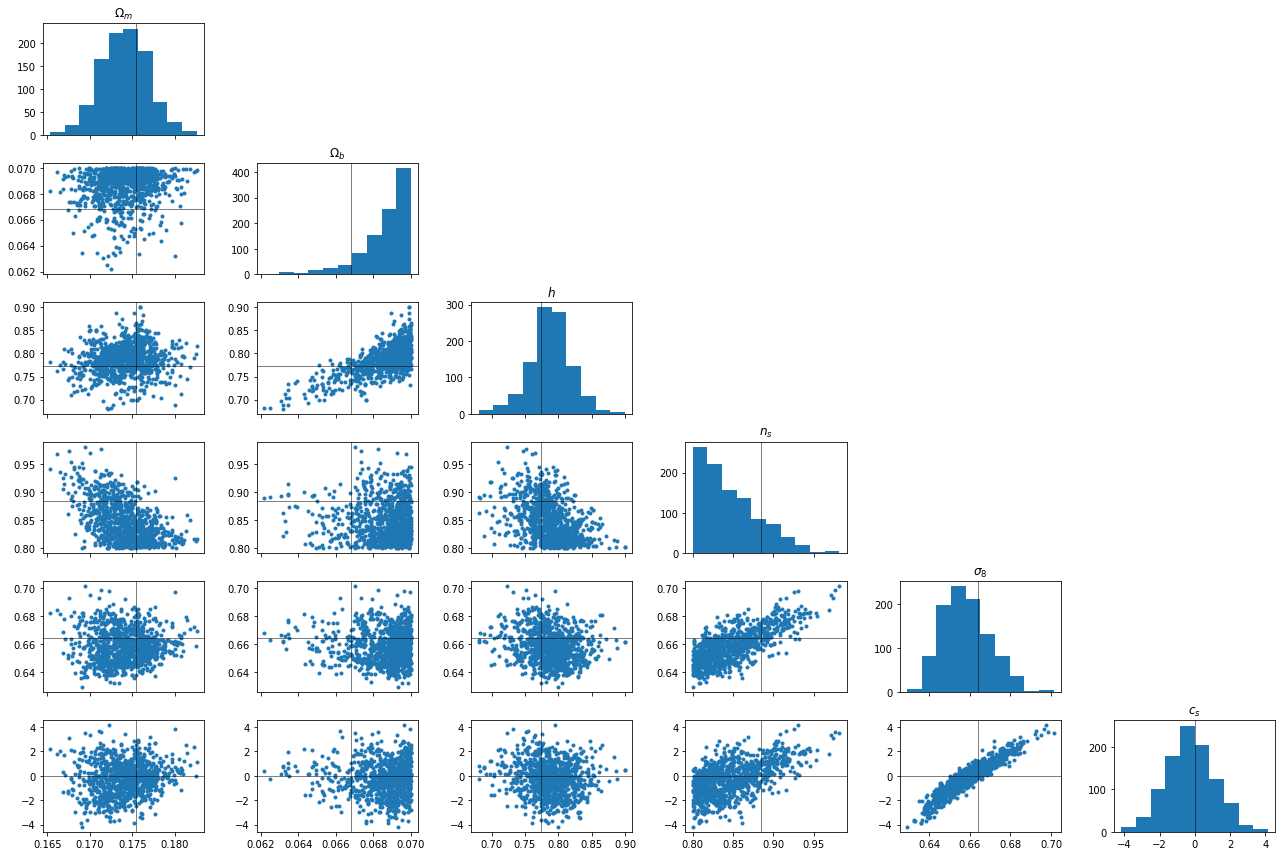

In [118]:
corner(f0[:, 0], truevals=list(params[0]) + [0], titles=cosmonames)



In [ ]:
fig, ax = plt.subplots(1, 5 , figsize=(20, 4))

for i in range(5):
    
    for j, ss in enumerate([f0, f1, f2, f3, f4, f5, f6]):
        ax[i].errorbar(j, ss[..., i].flatten().mean(), ss[..., i].flatten().std(), fmt='o', alpha=0.5, label='');
    
    ax[i].axhline(params[isim][i], color='k', lw=0.5)
    
ax[-1].legend()
plt.suptitle(f'LH{isim}')

In [ ]:
# plt.hist(f0[..., -1].flatten(), density=True);
plt.hist(f3[..., -1].flatten(), density=True);

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
idim = 4

for j in range(20):
    ax[0].plot(f0[:, j, idim], alpha=0.5)
# plt.axhline(params.min(axis=0)[idim], color='k')
# plt.axhline(params.max(axis=0)[idim], color='k')

plt.subplot(122)
for j in range(20):
    ax[1].plot(f1[:, j, idim], alpha=0.5)
# plt.axhline(params.min(axis=0)[idim], color='k')
# plt.axhline(params.max(axis=0)[idim], color='k')

# rankplots

In [14]:
def clean_chains(s, verbose=False):
    good = np.array([True] * s.shape[1])
    for idim in range(s.shape[-1]):
        esses = np.array(list(map(ess, s[..., idim].T)))
        # clean = (esses > 20)
        clean = (esses > (esses.mean() - 2.5*esses.std()))
        good *= clean
    if verbose: print("Bad chains dropped : ", good.size - good.sum())
    return s[:, good, :]


def narrow_prior(t=5):

    masks = np.ones(params.shape[0])
    for i in range(5):
        vals = params[:, i].copy()
        m0, m1 = vals.min(), vals.max()
        r = (m1-m0)*t/100.
        mask = np.ones(vals.size)
        mask[vals < m0 + r] = 0
        mask[vals > m1 - r] = 0
        masks *= mask
    return masks

prior_t5 = narrow_prior().astype(bool)
prior_t10 = narrow_prior(t=10).astype(bool)


In [9]:
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid_independent/emcee_chains/kmax0.5-kmin0.15-logit-nsubs1-splits2-standardize/ens5//LH%d.npy',
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits2-standardize-standardize_cond/ens10//LH%d.npy',
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits2-standardize-standardize_cond/ens10/LH%d.npy', 
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-nsubs1-splits2-standardize-standardize_cond/ens10/LH%d.npy',
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-nsubs2-splits2-standardize-standardize_cond/ens10/LH%d.npy',
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-logit-logit_cond-nsubs2-splits2-standardize-standardize_cond/ens10/LH%d.npy',
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-logit-logit_cond-nsubs4-splits2-standardize-standardize_cond/ens10/LH%d.npy',
# '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.001-ksplit0.1-logit-logit_cond-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',


In [21]:
path = '/mnt/ceph/users/cmodi/HySBI/matter/samples/'
runs = [f'{path}/PT/kmax0.15/LH%d.npy',
        f'{path}/PT_varycov/kmax0.15/LH%d.npy',
        f'{path}/PT/kmax0.1/LH%d.npy',
        f'{path}/PT/kmax0.2/LH%d.npy',
        f'{path}/snle_dk2/kmax0.5-kmin0.15-meanf-nsubs8-splits2-standardize-style-deconv/ens10/LH%d.npy',
        # f'{path}/snle_wronglp//emcee_chains/kmax0.5-kmin0.001-logit-standardize/ens5//LH%d.npy',
        f'{path}/snpe//kmax0.5-kmin0.001-logit-standardize/LH%d.npy',
        f'{path}/snle//kmax0.5-kmin0.001-logit-standardize/ens10/LH%d.npy',
        f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
        # f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
        f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        # f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        # f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs2-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs2-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        # f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens5//LH%d.npy',
        f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.1-meanf-nsubs8-splits2-standardize-standardize_cond/ens5/LH%d.npy',
        # f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        # f'{path}/hybrid2_sub/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        # f'{path}/hybrid2_small_sub/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        # f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/ens10/LH%d.npy',
        # f'{path}/hybrid2_sub/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/ens10/LH%d.npy',
        # f'{path}/hybrid2_small/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/ens10/LH%d.npy',
        f'{path}/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens5/LH%d.npy',
        f'{path}/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs4-splits2-standardize-standardize_cond-style-deconv/ens10/LH%d.npy',
        f'{path}/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs1-splits2-standardize-standardize_cond-style-deconv/ens10/LH%d.npy',
        f'{path}/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-sym/ens10/LH%d.npy',
        f'{path}/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens10/LH%d.npy',
        f'{path}/hybrid2_small_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens10/LH%d.npy',
        f'{path}/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.1-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens20/LH%d.npy',
        f'{path}/hybrid2_indep_dk2/kmax0.5-kmin0.15-meanf-nsubs8-splits2-standardize-style-deconv/ens10/LH%d.npy',
        f'{path}/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens10/LH%d.npy',
        f'{path}/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens10_varycov/LH%d.npy',
        f'{path}/hybrid2/J4-M4-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10_varycov/LH%d.npy',
        f'{path}/hybrid2_sub/J4-M4-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10_varycov/LH%d.npy',
        f'{path}/hybrid2/J3-M4-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        f'{path}/hybrid2/J3-M4-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10_varycov/LH%d.npy',
        f'{path}/hybrid2/J3-M3-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        f'{path}/hybrid2_small/J4-M4-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/J7-M4-Q3-kc0.67-logit-standardize/ens10/LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/J4-M4-Q4-kc0.67-logit-standardize/ens10/LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle//J3-M4-Q4-e0.1-kc0.67-logit-meanf-nsubs8-splits2-standardize/ens10//LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle_sub//J3-M4-Q4-e0.1-kc0.67-logit-meanf-nsubs8-splits2-standardize/ens10//LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/snpe_sub/J3-M4-Q4-e0.1-kc0.67-logit-meanf-nsubs8-splits2-standardize/ens10//LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/snpe/J3-M4-Q4-e0.1-kc0.67-logit-meanf-nsubs8-splits2-standardize/ens10//LH%d.npy',
        f'{path}/hybrid2/J3-M3-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        f'{path}/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens20_varycov/LH%d.npy',
        f'{path}/snle/J3-M4-Q4-e0.1-kc0.67-logit-nsubs8-splits2-standardize/ens10//LH%d.npy',
        f'{path}/snle/J3-M4-Q4-e0.02-kc0.67-logit-meanf-nsubs8-splits2-standardize/ens10//LH%d.npy',
        f'{path}/hybrid2/J3-M3-Q4-e0.02-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        f'{path}/hybrid2/J3-M3-Q4-e0.02-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10_varycov/LH%d.npy',
        f'{path}/hybrid2/J3-M4-Q4-e0.02-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10_varycov/LH%d.npy',
        f'{path}/hybrid2/J4-M4-Q4-e0.02-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10_varycov/LH%d.npy',
        f'{path}/hybrid2/J3-M3-Q4-e0.02-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs1-splits2-standardize-standardize_cond/ens10_varycov/LH%d.npy',
        f'{path}/hybrid2/J3-M4-Q4-e0.02-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs1-splits2-standardize-standardize_cond/ens10_varycov/LH%d.npy',
        
       ]



In [2]:
# !ls  '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens20_varycov/'
# !ls  '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_small/J2-M4-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/'
# !ls  '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle_sub//J2-M4-Q4-e0.1-kc0.67-logit-meanf-nsubs8-splits2-standardize/ens10//'
!ls  '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/J3-M4-Q4-e0.02-kc0.67-logit-meanf-nsubs8-splits2-standardize/ens10/




/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [4]:
run = runs[6]
print(run)
# os.path.pardir?
# !ls run

/mnt/ceph/users/cmodi/HySBI/matter/samples//snle//kmax0.15-kmin0.001-logit-standardize//LH%d.npy


/mnt/ceph/users/cmodi/HySBI/matter/samples//snle//kmax0.5-kmin0.001-logit-standardize/ens10/LH%d.npy
(160, 5, 4)


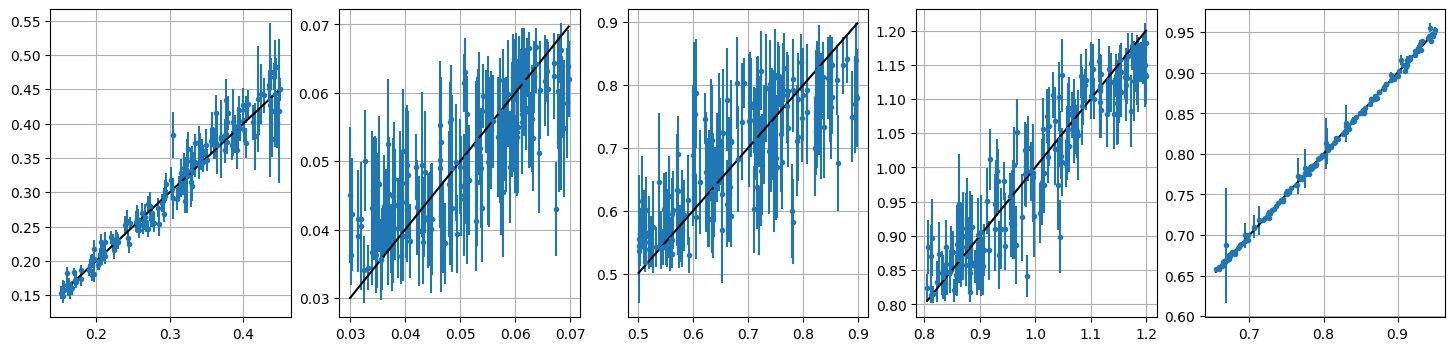

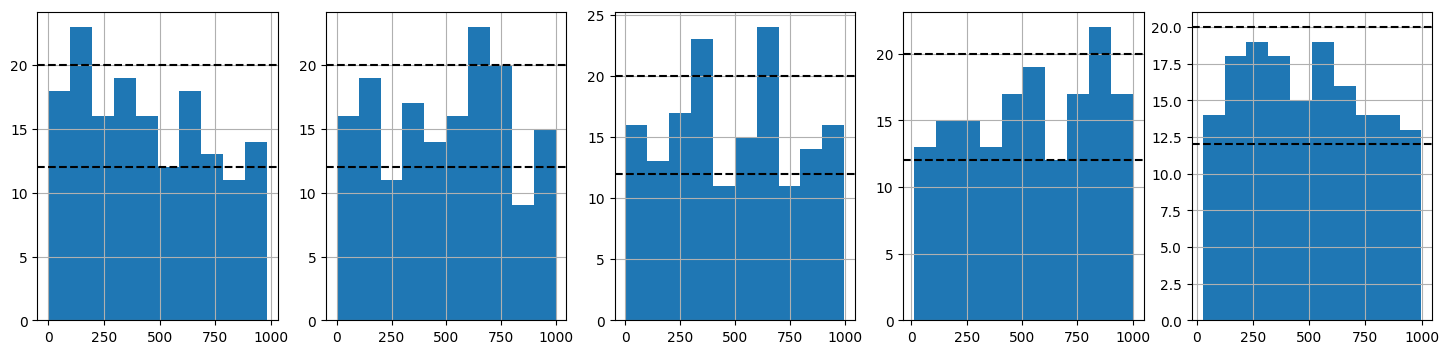

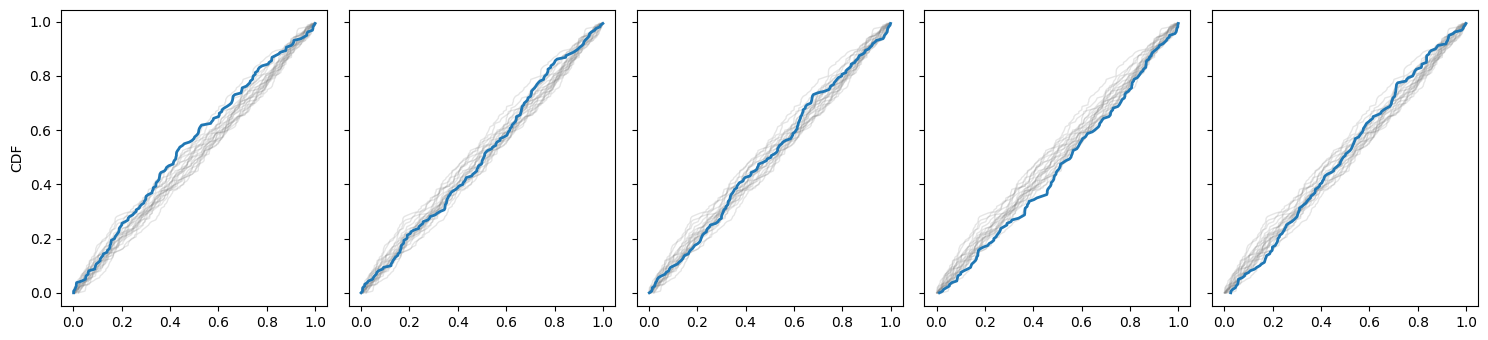

In [22]:
run = runs[6]
print(run)
nsims = len(testidx)
ss = []
allsamples = []
thin = 20
acs = []
for i in range(nsims):
    isim = testidx[i]
    
    # if prior_t10[isim] : #(0.15 < params[isim, 0] < 0.45) & (0.65 < params[isim, 4] < 0.95) :
    if True: #(0.15 < params[isim, 0] < 0.45) & (0.65 < params[isim, 4] < 0.95) :
        try:
            samples = (np.load(run%isim))
            # samples = clean_chains(np.load(run%isim))
            allsamples.append(samples)
        except Exception as e:
            # print(e)
            continue
        mu, std = samples.mean(axis=(0, 1)), samples.std(axis=(0, 1))
        
        # acs.append([np.array(list(map(iat_imse, (samples[:, :, idim].T)))).astype(int).max() for idim in range(5)])
        # ranks = [(samples[..., j] < params[isim, j]).sum() for j in range(5)]
        ranks = [(samples[::thin, :, j] < params[isim, j]).sum() for j in range(5)]
        
        ss.append(np.stack([params[isim], mu[:5], std[:5], ranks]).T)
ss = np.array(ss)
acs = np.array(acs)
# allsamples = np.array(allsamples)
print(ss.shape)    

##################################
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

for idim in range(5):
    ax[idim].errorbar(ss[:, idim, 0], ss[:, idim, 1], ss[:, idim, 2], fmt='.')
    ax[idim].plot([ss[:, idim, 0].min(), ss[:, idim, 0].max()], [ss[:, idim, 0].min(), ss[:, idim, 0].max()], 'k')
    ax[idim].grid(which='both')
plt.show()


##################################
nbins = 10 
h = ss.shape[0]/nbins
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

for idim in range(5):
    ax[idim].hist(ss[:, idim, 3], bins=nbins)
    ax[idim].axhline(h - h**.5, color='k', ls='--')
    ax[idim].axhline(h + h**.5, color='k', ls='--')
    ax[idim].grid(which='both')

plt.show()

##################################
ranks = ss[..., 3]
ncounts = ss.shape[0]
npars = 5
unicov = [np.sort(np.random.uniform(0, 1, ncounts)) for j in range(20)]

fig, ax = plt.subplots(1, npars, figsize=(npars*3, 3.5), sharex=True, sharey=True)

for i in range(5):
    xr = np.sort(ranks[:, i])
    xr = xr/xr[-1]
    cdf = np.arange(xr.size)/xr.size
    for j in range(len(unicov)): 
        ax[i].plot(unicov[j], cdf, lw=1, color='gray', alpha=0.2)
    ax[i].plot(xr, cdf, lw=2)
    # ax[i].set_title(titles[i])
    ax[0].set_ylabel('CDF')
plt.tight_layout()
plt.show()

###  loop over all

In [16]:
from arviz import rhat, ess, autocorr



/snpe//kmax0.5-kmin0.001-logit-standardize
ss shape :  (121, 5, 4)


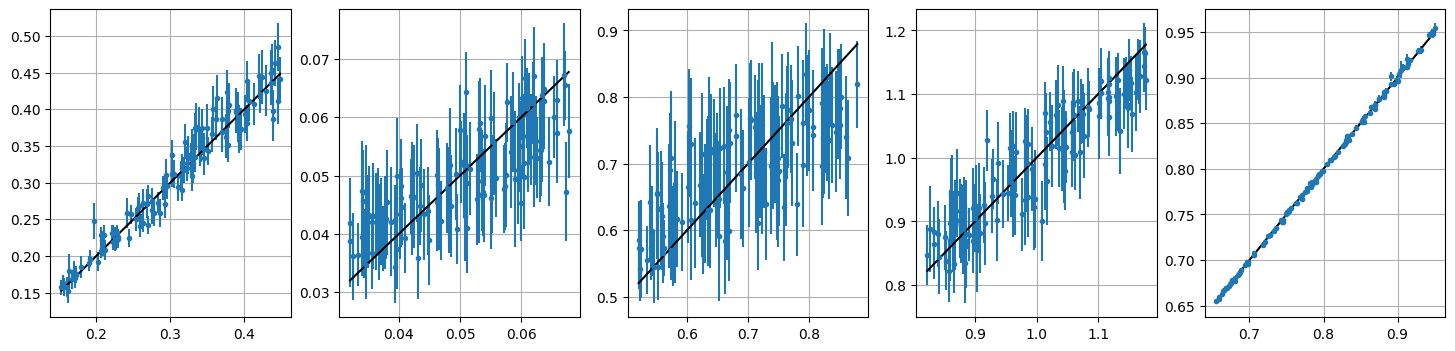

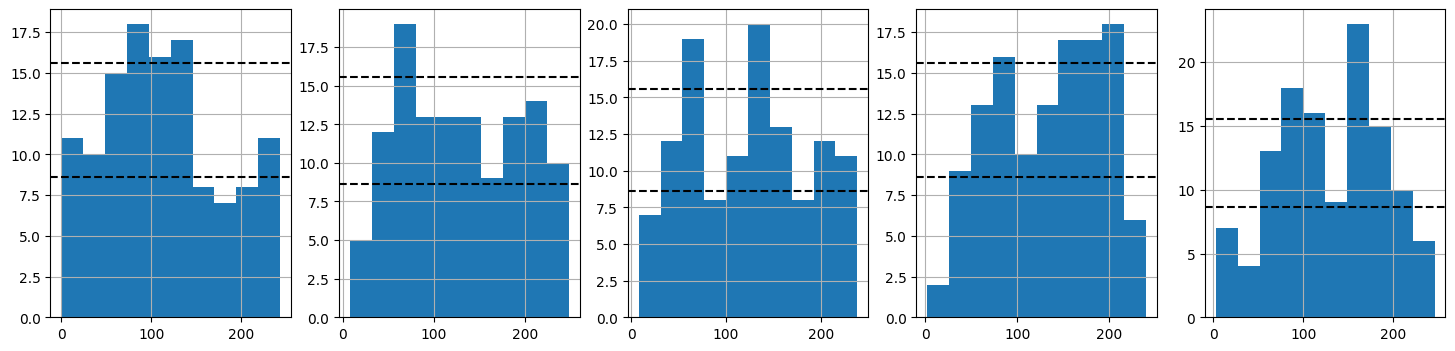

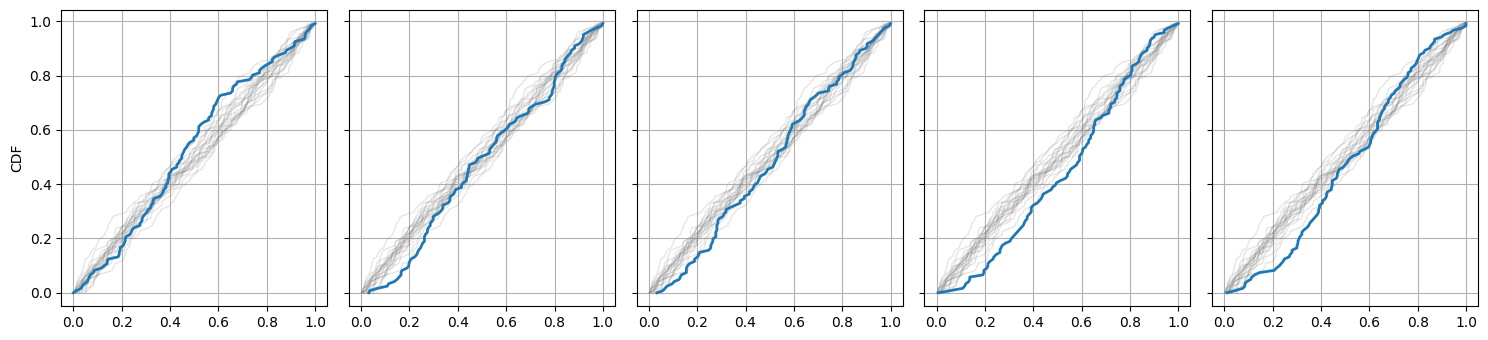


/snle//kmax0.5-kmin0.001-logit-standardize/ens10
ss shape :  (121, 5, 4)


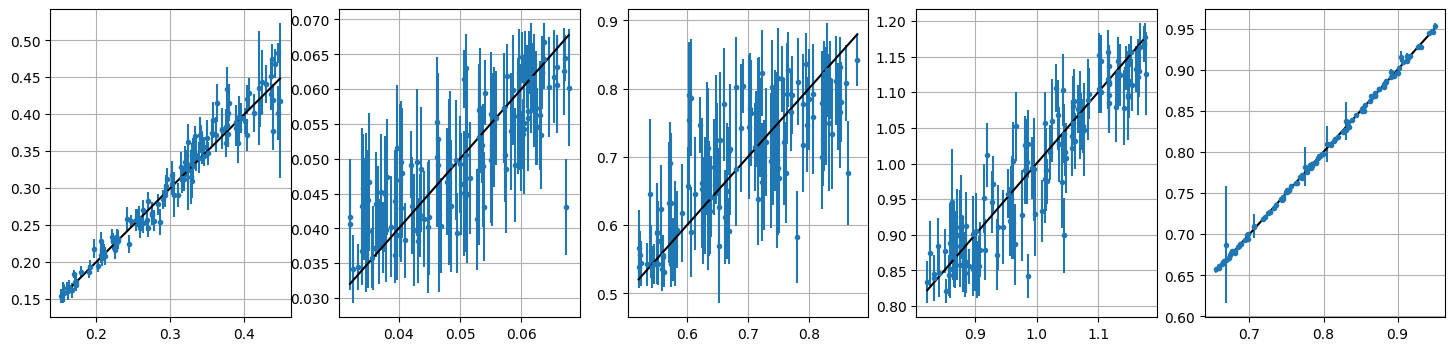

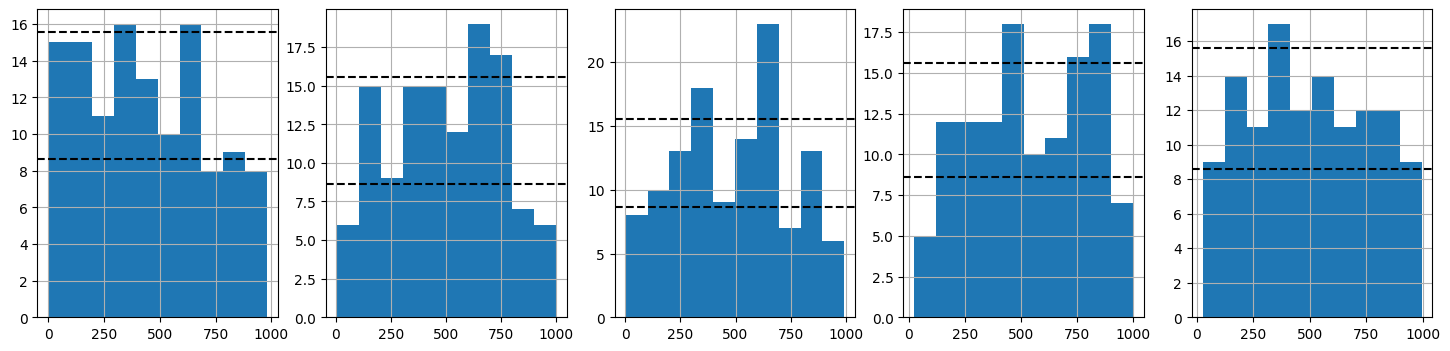

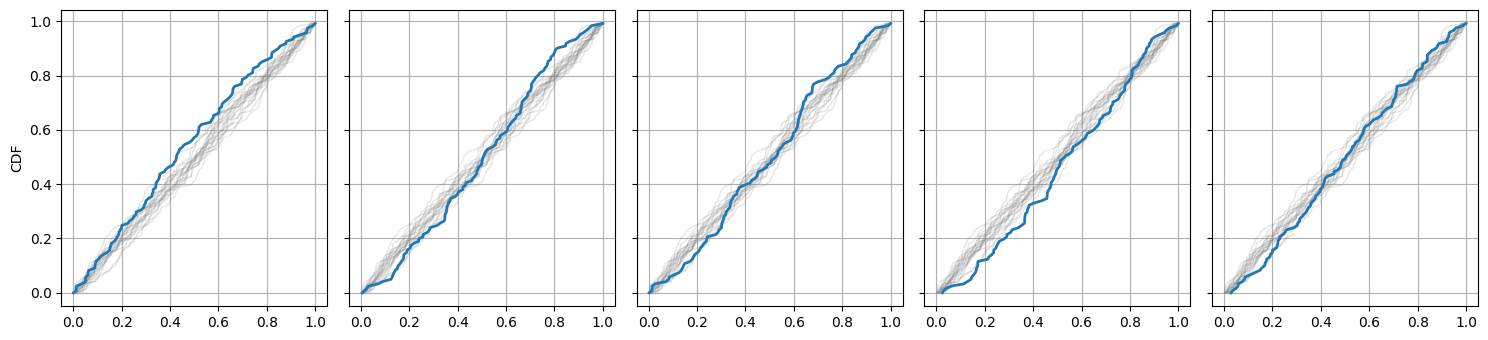

In [25]:
nsims = len(testidx)
nbins = 10
thin = 20

esses, rhats = [], []
for run in runs[5:7]:
    print()
    print('/'.join(run.split('/')[8:-1]))
    # if 'splits1' in run: continue
    ss = []
    for i in range(nsims):
        isim = testidx[i]
        # isim = goodids[i]

        # if  (0.15 < params[isim, 0] < 0.45) & (0.65 < params[isim, 4] < 0.95) :
        # if  (0.2 < params[isim, 0] < 0.4) & (0.65 < params[isim, 4] < 0.9) :
        if prior_t5[isim]:
        # if True:
            try:
                # samples = clean_chains(np.load(run%isim))
                samples = np.load(run%isim)
            except Exception as e:
                continue #print(e)
            mu, std = samples.mean(axis=(0, 1)), samples.std(axis=(0, 1))
            ranks = [(samples[::thin, :, j] < params[isim, j]).sum() for j in range(5)]
            ss.append(np.stack([params[isim], mu[:5], std[:5], ranks]).T)
            
    ss = np.array(ss)
    print("ss shape : ", ss.shape)
    if ss.shape[0] == 0:
        print("NO SAMPLES FOUND")
        continue
    fig, ax = plt.subplots(1, 5, figsize=(18, 4))
    for idim in range(5):
        ax[idim].errorbar(ss[:, idim, 0], ss[:, idim, 1], ss[:, idim, 2], fmt='.')
        ax[idim].plot([ss[:, idim, 0].min(), ss[:, idim, 0].max()], [ss[:, idim, 0].min(), ss[:, idim, 0].max()], 'k')
        ax[idim].grid(which='both')
    plt.show()
    

    fig, ax = plt.subplots(1, 5, figsize=(18, 4))
    h = ss.shape[0]/nbins
    for idim in range(5):
        ax[idim].hist(ss[:, idim, 3], bins=nbins)
        ax[idim].axhline(h - h**.5, color='k', ls='--')
        ax[idim].axhline(h + h**.5, color='k', ls='--')
        ax[idim].grid(which='both')
    plt.show()
    
    
    ##################################
    ranks = ss[..., 3]
    ncounts = ss.shape[0]
    npars = 5
    unicov = [np.sort(np.random.uniform(0, 1, ncounts)) for j in range(20)]

    fig, ax = plt.subplots(1, npars, figsize=(npars*3, 3.5), sharex=True, sharey=True)

    for i in range(5):
        xr = np.sort(ranks[:, i])
        xr = xr/xr[-1]
        cdf = np.arange(xr.size)/xr.size
        for j in range(len(unicov)): 
            ax[i].plot(unicov[j], cdf, lw=1, color='gray', alpha=0.2)
        ax[i].plot(xr, cdf, lw=2)
        # ax[i].set_title(titles[i])
        ax[0].set_ylabel('CDF')
        ax[i].grid(which='both')
    plt.tight_layout()
    plt.show()

## for good ids

865 [0.3199  0.04035 0.7235  1.0251  0.8329 ]


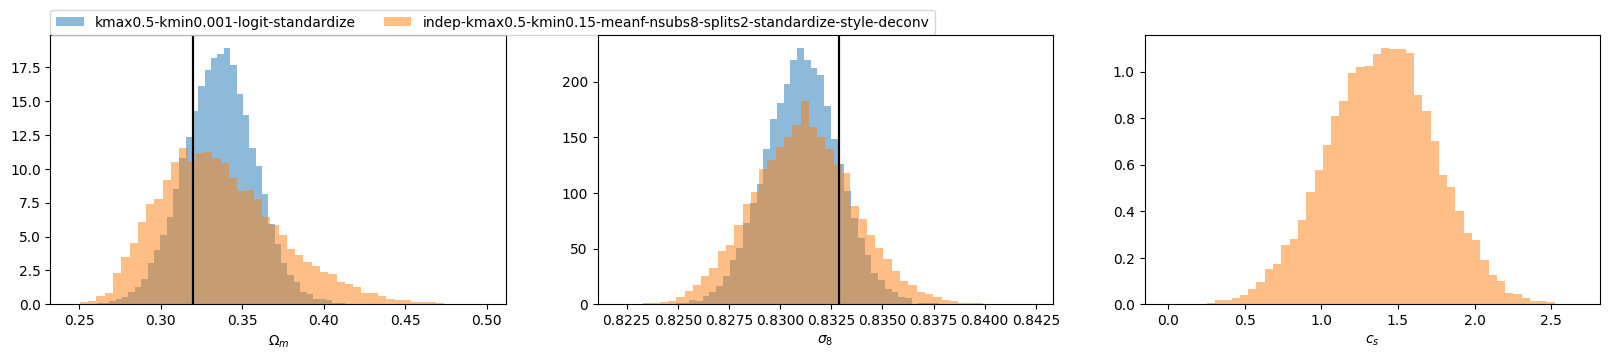

663 [0.3223  0.04625 0.7015  0.9607  0.8311 ]


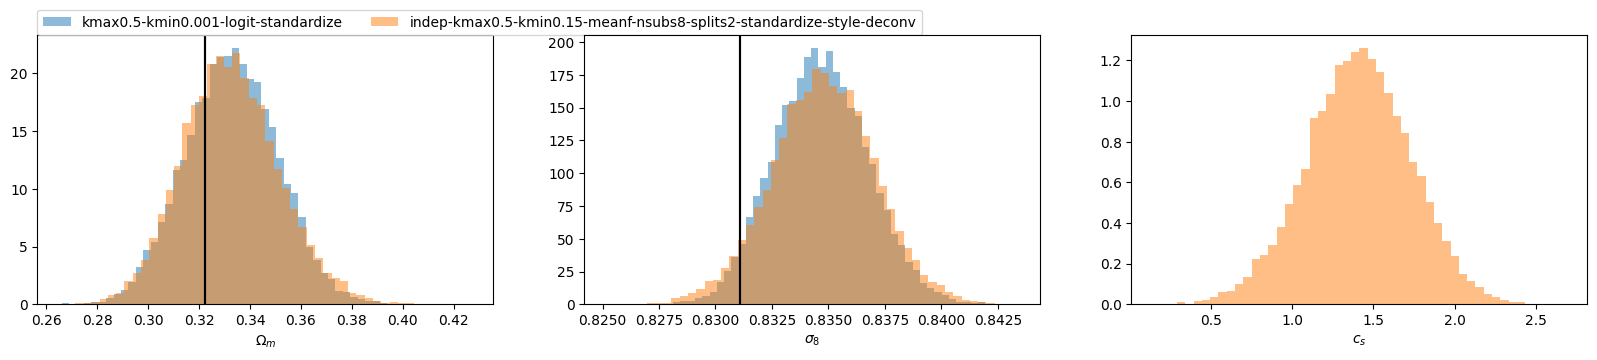

1964 [0.3157  0.05723 0.7491  0.9563  0.8091 ]


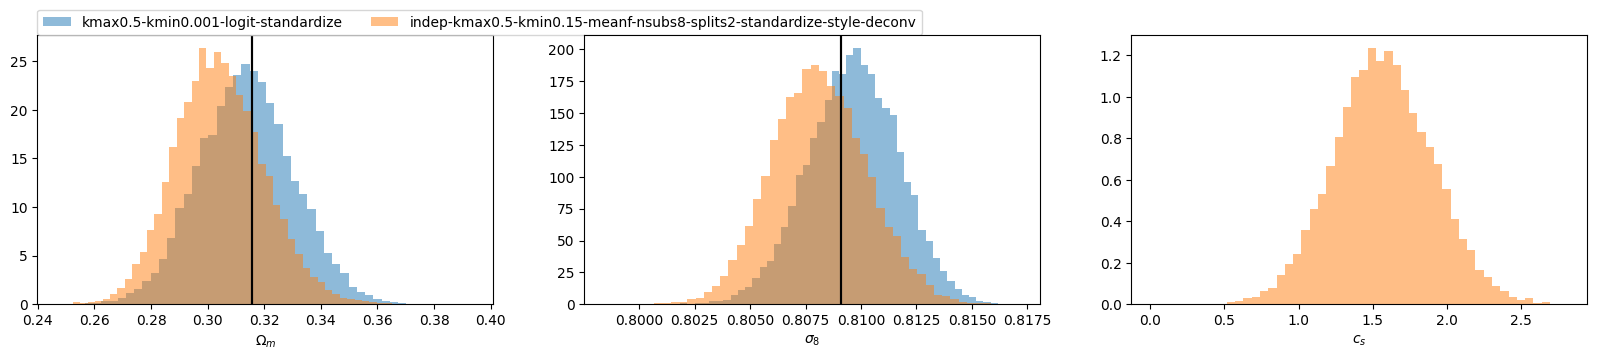

121 [0.2541  0.04943 0.7997  0.9459  0.8819 ]


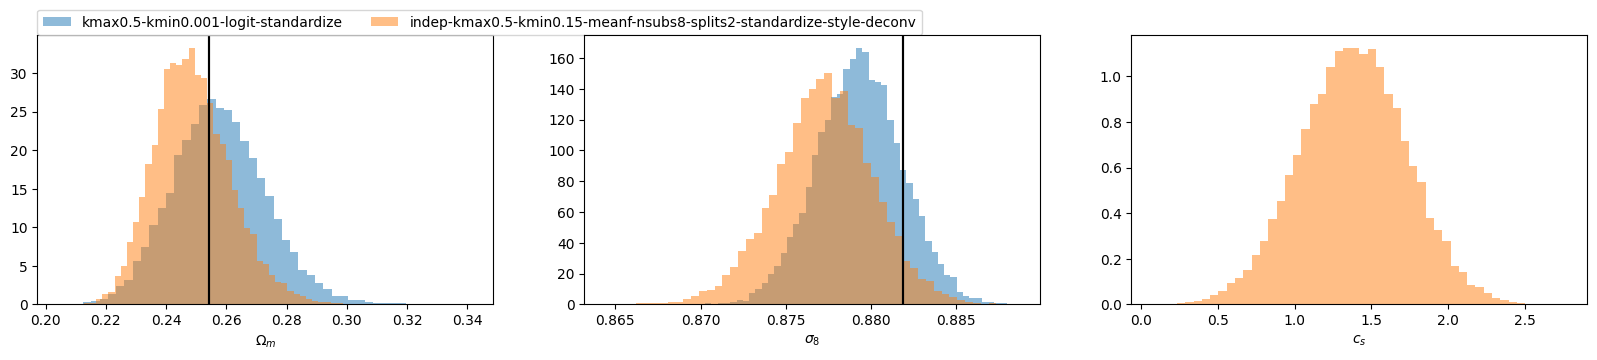

696 [0.2057  0.05959 0.7193  1.0443  0.8343 ]


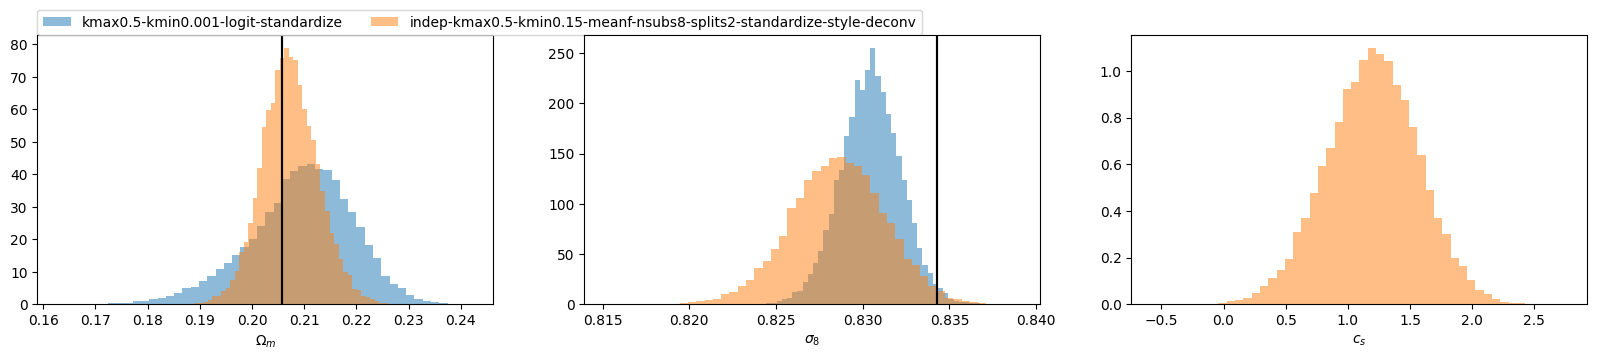

1539 [0.3149  0.05077 0.7161  0.9655  0.8847 ]


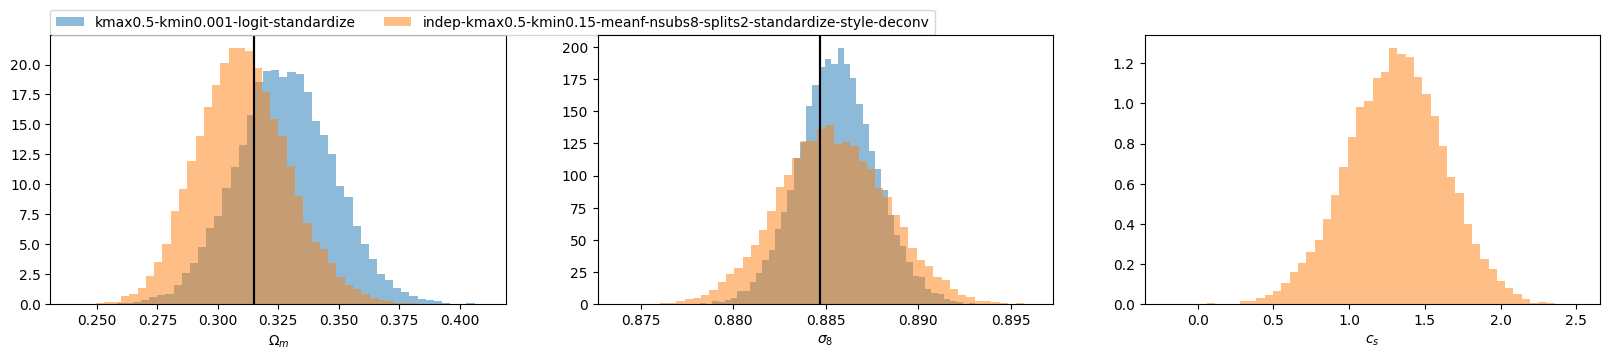

1329 [0.3403  0.05119 0.7409  0.9357  0.8915 ]
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/kmax0.5-kmin0.001-logit-standardize/LH1329.npy'


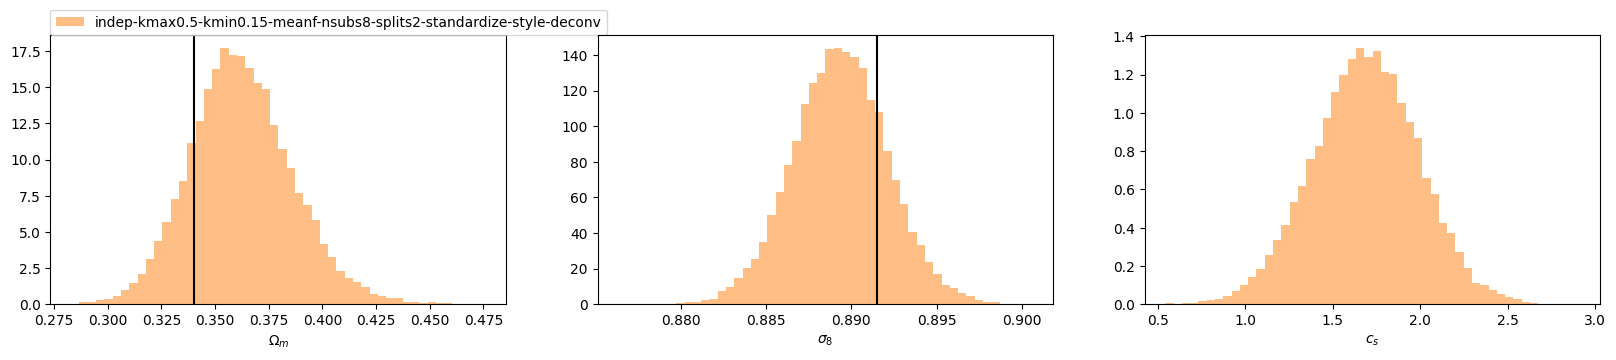

909 [0.3349  0.04321 0.7655  1.0095  0.7535 ]
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/kmax0.5-kmin0.001-logit-standardize/LH909.npy'


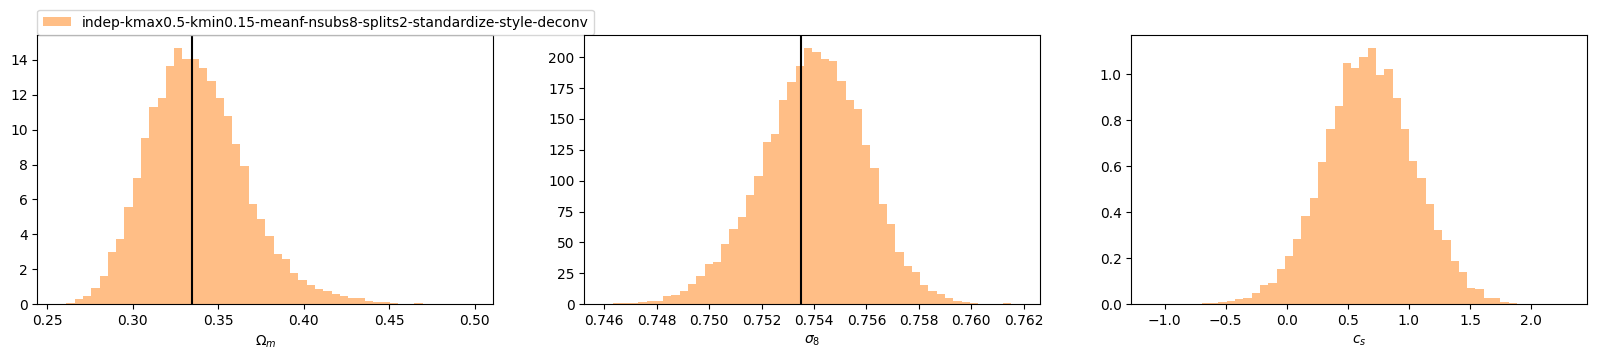

964 [0.3151  0.04039 0.6893  0.9023  0.7923 ]
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/kmax0.5-kmin0.001-logit-standardize/LH964.npy'


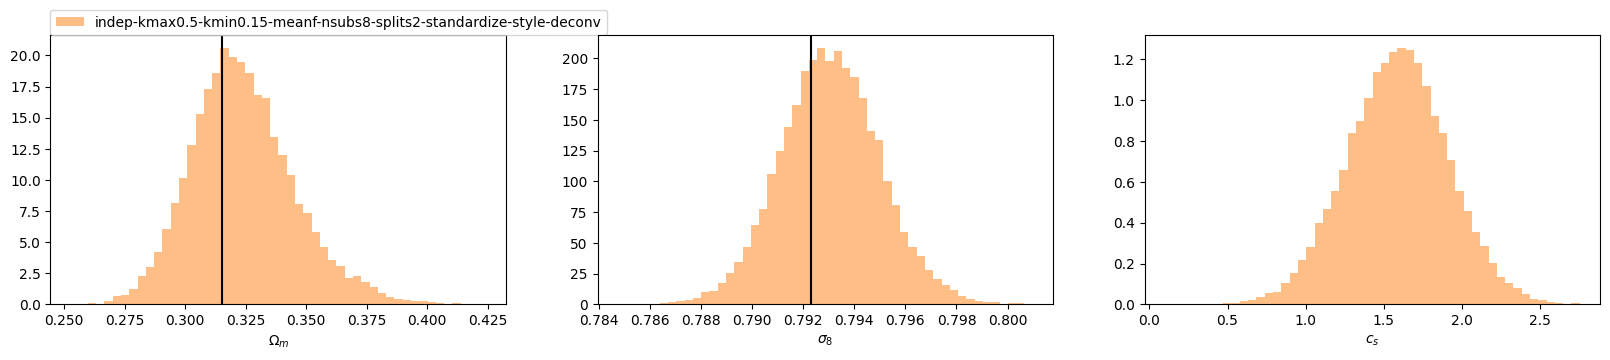

In [639]:
toplot = [
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/PT/kmax0.15/LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/kmax0.5-kmin0.001-logit-standardize/LH%d.npy',
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-sym/ens10/LH%d.npy',
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens5/LH%d.npy',
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens10/LH%d.npy',
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens10_varycov/LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_indep_dk2/kmax0.5-kmin0.15-meanf-nsubs8-splits2-standardize-style-deconv/ens10/LH%d.npy',
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens10/LH%d.npy',
]

for isim in goodids:
    
    print(isim, params[isim])
    fig, ax = plt.subplots(1, 3, figsize=(20, 3.5))
    
    for ik, key in enumerate(toplot):
        try:
            ss = clean_chains(np.load(key%isim))
            lbl = None

            j = 0 
            for i in range(ss.shape[-1]):
                if i in [1, 2, 3]: continue
                if i == 0 :
                    lbl = [j for j in key.split('/') if 'kmax' in j][0]
                    if 'varycov' in key : lbl += '-varycov'
                    if 'indep' in key : lbl = 'indep-'+lbl
                    
                    # lbl = labels[ik]
                ax[j].hist(ss[..., i].flatten(), density=True, bins=50, alpha=0.5, color=f"C{ik}", label=lbl)
                # ax[j].axvline(ss[..., i].mean(), alpha=0.7, color=f"C{ik}")
                # ax[j].axvline(ss[..., i].mean() + ss[..., i].std(), alpha=0.7, color=f"C{ik}", ls="--")
                # ax[j].axvline(ss[..., i].mean() - ss[..., i].std(), alpha=0.7, color=f"C{ik}", ls="--")
                ax[j].set_xlabel(cosmonames[i])
                if i < 5: ax[j].axvline(params[isim, i], color='k')
                j+=1
        except Exception as e:
            print(e)
    ax[0].legend(loc=(0, 1), ncol=2)
    # plt.suptitle(f'LH : {isim}')
    # plt.tight_layout()
    plt.show()


# Check for a sim

In [623]:
ss.shape

(1000, 20, 6)

1447 [0.2735  0.03137 0.7331  0.9963  0.7381 ]


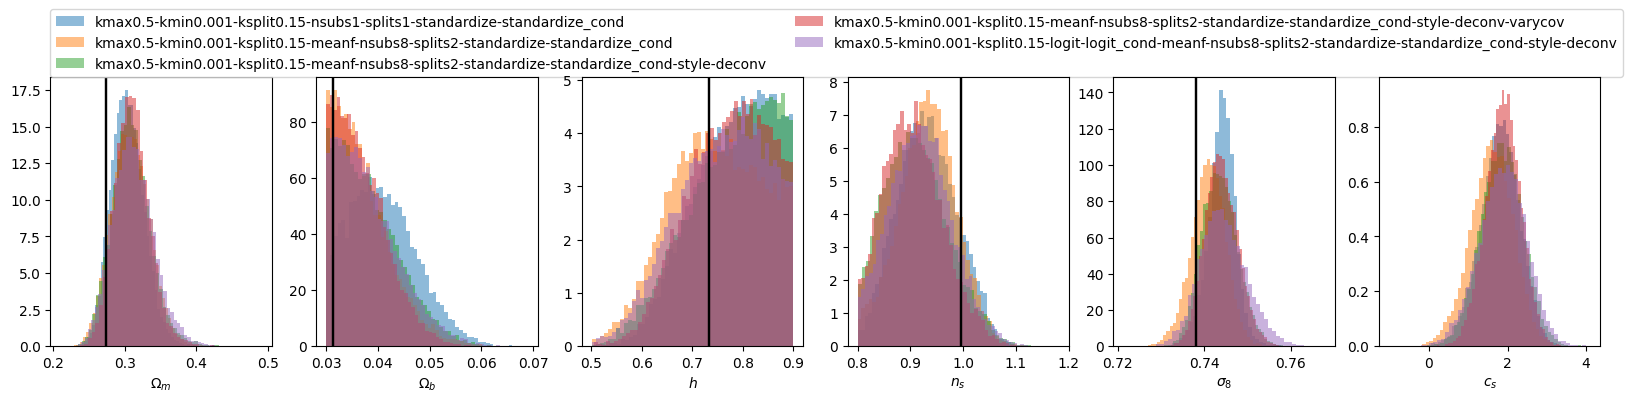

In [628]:
toplot = [
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/PT/kmax0.15/LH%d.npy',
    
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/ens10/LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH%d.npy',
        # '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens5/LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens10/LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens10_varycov/LH%d.npy',
        '/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_dk2/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv/ens10/LH%d.npy',
]

i = 4
isim = testidx[i]
print(isim, params[isim])

# fig, ax = plt.subplots(1, 3, figsize=(20, 3.5))
fig, ax = plt.subplots(1, 6, figsize=(20, 3.5))
 
for ik, key in enumerate(toplot):
    
    try:
        ss = clean_chains(np.load(key%isim))
        lbl = None

        j = 0 
        for i in range(ss.shape[-1]):
            # if i in [1, 2, 3]: continue
            if i == 0 :
                lbl = [j for j in key.split('/') if 'kmax' in j][0]
                if 'varycov' in key : lbl += '-varycov'
                # lbl = labels[ik]
            ax[j].hist(ss[..., i].flatten(), density=True, bins=50, alpha=0.5, color=f"C{ik}", label=lbl)
            # ax[j].axvline(ss[..., i].mean(), alpha=0.7, color=f"C{ik}")
            # ax[j].axvline(ss[..., i].mean() + ss[..., i].std(), alpha=0.7, color=f"C{ik}", ls="--")
            # ax[j].axvline(ss[..., i].mean() - ss[..., i].std(), alpha=0.7, color=f"C{ik}", ls="--")
            ax[j].set_xlabel(cosmonames[i])
            if i < 5: ax[j].axvline(params[isim, i], color='k')
            j+=1
    except Exception as e:
        print(e)
ax[0].legend(loc=(0, 1), ncol=2)
# plt.tight_layout()
# plt.suptitle(f'LH : {isim}')
plt.show()


# check log prob distribution

In [91]:
import yaml
from wandb import Api
api = Api()

In directory /mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid/J2-M2-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/
Sweep found : q0qdwem3


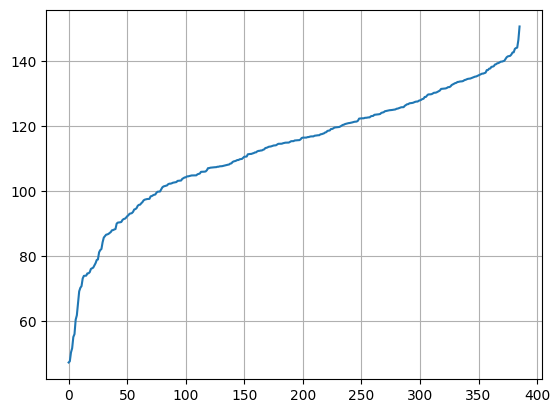

In [147]:
# analysis_path = '/mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/'
# analysis_path = '/mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid/kmax0.5-kmin0.001-ksplit0.1-logit-logit_cond-nsubs8-splits2-standardize-standardize_cond/'
analysis_path = '/mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid/J2-M2-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/'
cfg_path = sbitools.insert_sweep_name(analysis_path)
cfg_dict = yaml.load(open(f'{cfg_path}/sweep_config.yaml'), Loader=yaml.Loader)
sweep_id = cfg_dict['sweep']['id']
args = {}
for i in cfg_dict.keys():
    args.update(**cfg_dict[i])
cfg = sbitools.Objectify(**args)

sweep = api.sweep(f'modichirag92/hysbi/{sweep_id}')
names, log_prob = [], []
for run in sweep.runs:
    if run.state == 'finished':
        # print(run.name, run.summary['best_validation_log_prob'])                                                                                                                                                                                                                                                        
        try:
            model_path = run.summary['output_directory']
            names.append(run.name)
            log_prob.append(run.summary['best_validation_log_prob'])
        except Exception as e:
            print('Exception in checking state of run : ', e)
idx = np.argsort(log_prob)[::-1]
names = np.array(names)[idx]

plt.plot(np.array(log_prob)[idx][::-1])
# plt.plot(np.array(log_prob)[idx])
plt.grid(which='both')
# plt.yscale('log')

(133.7134577433268, 150.6288579305013)

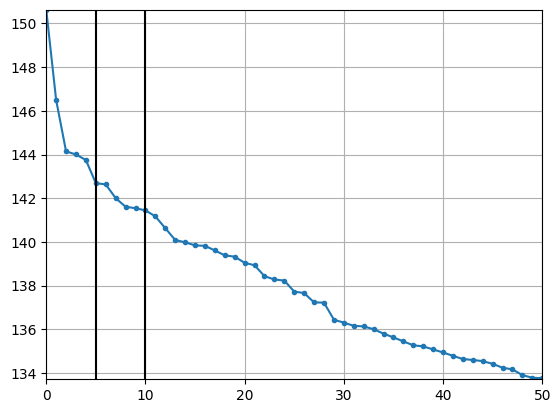

In [148]:
plt.plot(np.array(log_prob)[idx], marker='.')
plt.axvline(5, color='k')
plt.axvline(10, color='k')
# plt.plot(np.array(log_prob)[idx])
plt.grid(which='both')
plt.xlim(0, 50)
plt.ylim(np.array(log_prob)[idx][51], np.array(log_prob)[idx][0])
# plt.yscale('log')

# Compare with Oliver

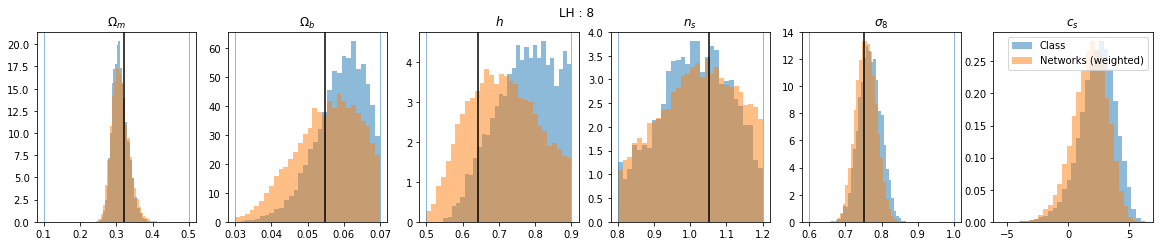

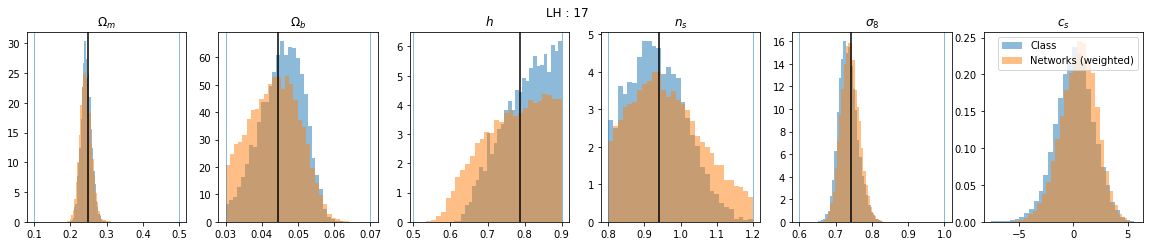

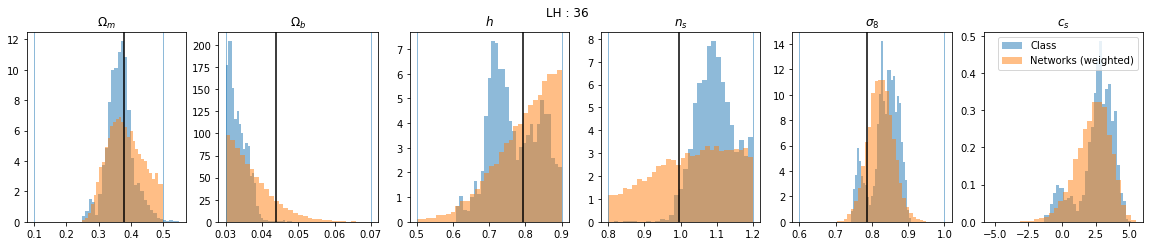

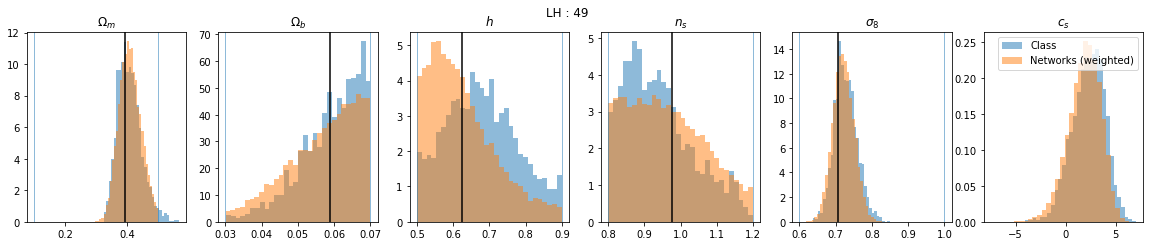

In [329]:
lh = 8
# lh = 36
# lh = 17
# lh = 49

for lh in [8, 17, 36, 49]:
    s0file = np.load(f'../data/samples_k015_sim{lh}.npz')
    s0file2 = np.load(f'../data/samples_k015_sim{lh}_v4_final_FINAL.npz')
    s1 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/PT//emcee_chains/kmax0.15/LH{lh}.npy')
    # s0file = np.load(f'../data/samples_k010_sim{lh}.npz')
    # s1 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/PT//emcee_chains/kmax0.1/LH{lh}.npy')
    s0 = s0file['samples']
    s02 = s0file2['samples']
    s0wts = s0file['weights']
    s0wts2 = s0file2['weights']


    fig, ax = plt.subplots(1, 6, figsize=(20, 3.5))

    for i in range(6):
        # ax[i].hist(s0[..., i].flatten(), density=True, bins=30, label='Class')
        ax[i].hist(s02[..., i].flatten(), density=True, bins=30, label='Class', alpha=0.5)
        # ax[i].hist(s0[..., i].flatten(), weights=s0wts, density=True, alpha=0.5, bins=30, label='Class (weighted)')
        ax[i].hist(s1[..., i].flatten(), alpha=0.5, density=True, bins=30, label='Networks (weighted)')
        ax[i].set_title(cosmonames[i])
        if i< 5:
            ax[i].axvline(params[lh, i], color='k')
            ax[i].axvline(params.min(axis=0)[i], lw=0.5)
            ax[i].axvline(params.max(axis=0)[i], lw=0.5)
    ax[-1].legend()
    plt.suptitle(f'LH : {lh}')
    plt.show()


In [357]:
tparams = params[testidx].copy()

In [161]:
i = 0 
for p in tparams:
    if  (0.15 < p[0] < 0.45) & (0.65 < p[4] < 0.95) :
        i+=1

In [441]:
idx = []
p00, p01 = 0.15, 0.45
p40, p41 = 0.65, 0.95
for i in testidx:
    p = params[i]
    if  (p00 < p[0] < p01) & (p40 < p[4] < p41) :
        idx.append(i)

In [175]:
# np.save(f'../data/testidx_p0-{p00}-{p01}_p4-{p40}-{p41}', idx)

In [177]:
# np.load('/mnt/home/cmodi/Research/Projects/HySBI/data/testidx_p0-0.15-0.45_p4-0.65-0.95.npy').size

160

# check change on correct runs

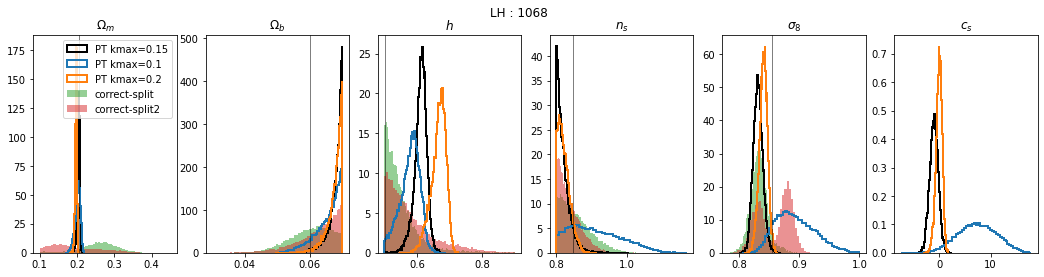

In [386]:
lh = testidx[0]

ss = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/PT/kmax0.15/LH{lh}.npy')
ss2 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/PT/kmax0.1/LH{lh}.npy')
ss3 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/PT/kmax0.2/LH{lh}.npy')

# s2 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//emcee_chains/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/ens10//LH{lh}.npy')
# s22 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//emcee_chains/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits2-standardize-standardize_cond/ens10//LH{lh}.npy')
# s23 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//emcee_chains/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits1-standardize-standardize_cond/ens10//LH{lh}.npy')

s2 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_small/kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/ens10//LH{lh}.npy')
s22 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_small/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond//ens10//LH{lh}.npy')
# 
fig, ax = plt.subplots(1, 6, figsize=(18, 4))

nbins = 'auto'

j = 0 
for i in [0, 1, 2, 3, 4, 5]:
    ax[j].hist(ss[..., i].flatten(), density=True, bins=nbins, label='PT kmax=0.15', histtype='step', color='k', lw=2)
    ax[j].hist(ss2[..., i].flatten(), density=True, bins=nbins, label='PT kmax=0.1', histtype='step',  lw=2)
    ax[j].hist(ss3[..., i].flatten(), density=True, bins=nbins, label='PT kmax=0.2', histtype='step',  lw=2)
    if i < 5:
        ax[j].hist(s2[..., i].flatten(), density=True, bins=nbins, label='correct-split', alpha=0.5)
        ax[j].hist(s22[..., i].flatten(), density=True, bins=nbins, label='correct-split2', alpha=0.5)
    # ax[j].hist(s23[..., i].flatten(), density=True, bins=nbins, label='correct-split2', alpha=0.5)
    ax[j].set_title(cosmonames[i])
    if i< 5:
        ax[j].axvline(params[lh, i], lw=0.5, color='k')
        # ax[i].axvline(params.min(axis=0)[i], lw=0.5)
        # ax[i].axvline(params.max(axis=0)[i], lw=0.5)
    j += 1
ax[0].legend()
plt.suptitle(f'LH : {lh}')
plt.show()



In [ ]:
lh = testidx[10]

s2 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/ens10//LH{lh}.npy'))
s22 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits2-standardize-standardize_cond/ens10//LH{lh}.npy'))
# s23 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//emcee_chains/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits1-standardize-standardize_cond/ens10//LH{lh}.npy'))
# s24 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//emcee_chains/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs1-splits2-standardize-standardize_cond/ens10//LH{lh}.npy'))
# s25 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//emcee_chains/kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-nsubs2-splits2-standardize-standardize_cond/ens10//LH{lh}.npy'))

s32 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10//LH{lh}.npy'))
s33 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs2-splits2-standardize-standardize_cond/ens10//LH{lh}.npy'))

s4 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2//dk2-kmax0.5-kmin0.001-ksplit0.15-logit-logit_cond-meanf-nsubs8-splits2-standardize-standardize_cond/ens10//LH{lh}.npy'))

s5 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp//ens10//LH{lh}.npy'))

fig, ax = plt.subplots(1, 6, figsize=(18, 4))

nbins = 'auto'

j = 0 
for i in [0, 1, 2, 3, 4, 5]:
    ax[j].hist(s2[..., i].flatten(), density=True, bins=nbins, label='split 1', alpha=0.5)    
    # ax[j].hist(s22[..., i].flatten(), density=True, bins=nbins, label='split 2', alpha=0.5)
    # ax[j].hist(s23[..., i].flatten(), density=True, bins=nbins, label='split 1-log', alpha=0.5)
    # ax[j].hist(s24[..., i].flatten(), density=True, bins=nbins, label='split 2-log', alpha=0.5)
    # ax[j].hist(s25[..., i].flatten(), density=True, bins=nbins, label='split 2-log-2box', alpha=0.5)
    ax[j].hist(s32[..., i].flatten(), density=True, bins=nbins, label='split 8-avg', alpha=0.5)
    # ax[j].hist(s33[..., i].flatten(), density=True, bins=nbins, label='split 2-avg', alpha=0.5)
    ax[j].hist(s5[..., i].flatten(), density=True, bins=nbins, label='deconv', alpha=0.5)
    ax[j].set_title(cosmonames[i])
    if i< 5:
        ax[j].axvline(params[lh, i], lw=0.5, color='k')
    j += 1
ax[-1].legend(bbox_to_anchor=(1, 1))
plt.suptitle(f'LH : {lh}')
plt.show()



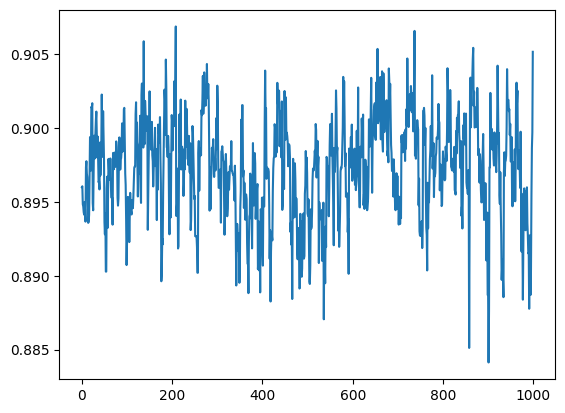

In [49]:
s22.shape
j = 12
plt.plot(s5[..., j, -2])
# plt.plot(s22[..., j, -2])

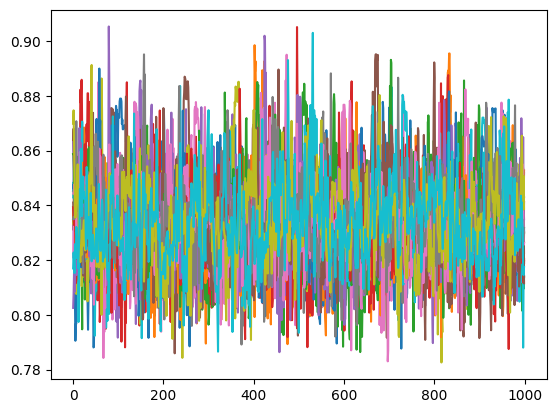

In [140]:
plt.plot(s2[...,  -1]);
# plt.plot(s22[..., j, -1])

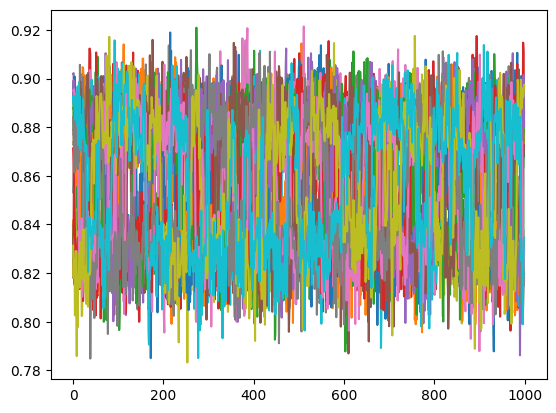

In [139]:
plt.plot(s22[..., -1]);

In [50]:
list(map(ess, s5[:, :, 0].T))

[110.43313718439552,
 87.56073813837334,
 75.81902986417433,
 106.79595999385896,
 109.02996630781102,
 139.64726584991413,
 87.20580096373166,
 102.30954071955574,
 111.70388103556664,
 93.84034287564822,
 118.28309048791374,
 77.70109785862846,
 110.31235949154855,
 131.83697413985269,
 93.05257728493739,
 70.10875669479807,
 121.44095928892689]

# check snle

Bad chains dropped :  1
Bad chains dropped :  4
Bad chains dropped :  2
Bad chains dropped :  2
Bad chains dropped :  3


No handles with labels found to put in legend.


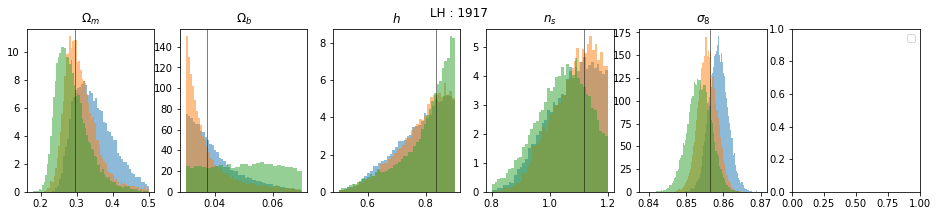

In [302]:
lh = testidx[45]

s0 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/kmax0.5-kmin0.15-logit-standardize/LH{lh}.npy'))
s1 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/dk1-kmax0.5-kmin0.15-logit-meanf-nsubs8-splits2-standardize/LH{lh}.npy'))
s2 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/dk2-kmax0.5-kmin0.15-logit-meanf-nsubs8-splits2-standardize/LH{lh}.npy'))
s1_sub = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle_sub//emcee_chains/dk1-kmax0.5-kmin0.15-logit-meanf-nsubs8-splits2-standardize/LH{lh}.npy'))
s2_sub = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle_sub//emcee_chains/dk2-kmax0.5-kmin0.15-logit-meanf-nsubs8-splits2-standardize/LH{lh}.npy'))

fig, ax = plt.subplots(1, 6, figsize=(16, 3))

nbins = 'auto'

j = 0 
for i in [0, 1, 2, 3, 4]:
    ax[j].hist(s0[..., i].flatten(), density=True, bins=nbins, label='split 1', alpha=0.5)    
    ax[j].hist(s1[..., i].flatten(), density=True, bins=nbins, label='split 2', alpha=0.5)
    ax[j].hist(s2[..., i].flatten(), density=True, bins=nbins, label='split 2', alpha=0.5)
    # ax[j].hist(s1_sub[..., i].flatten(), density=True, bins=nbins, label='split 2', alpha=0.5)
    # ax[j].hist(s2_sub[..., i].flatten(), density=True, bins=nbins, label='split 2', alpha=0.5)
    
    ax[j].set_title(cosmonames[i])
    if i< 5:
        ax[j].axvline(params[lh, i], lw=0.5, color='k')
        # ax[i].axvline(params.min(axis=0)[i], lw=0.5)
        # ax[i].axvline(params.max(axis=0)[i], lw=0.5)
    j += 1
ax[-1].legend()
plt.suptitle(f'LH : {lh}')
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


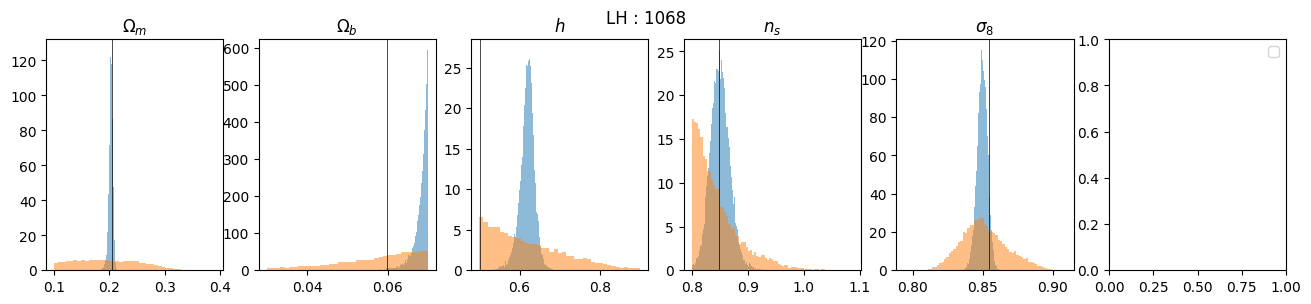

In [301]:
lh = testidx[0]

s0 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_sub/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10/LH{lh}.npy'))
s1 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_small_sub/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/ens10//LH{lh}.npy'))
# s2 = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/dk2-kmax0.5-kmin0.15-logit-meanf-nsubs8-splits2-standardize/LH{lh}.npy'))
# s1_sub = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle_sub//emcee_chains/dk1-kmax0.5-kmin0.15-logit-meanf-nsubs8-splits2-standardize/LH{lh}.npy'))
# s2_sub = clean_chains(np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle_sub//emcee_chains/dk2-kmax0.5-kmin0.15-logit-meanf-nsubs8-splits2-standardize/LH{lh}.npy'))

fig, ax = plt.subplots(1, 6, figsize=(16, 3))

nbins = 'auto'

j = 0 
for i in [0, 1, 2, 3, 4]:
    ax[j].hist(s0[..., i].flatten(), density=True, bins=nbins, label='split 1', alpha=0.5)    
    ax[j].hist(s1[..., i].flatten(), density=True, bins=nbins, label='split 2', alpha=0.5)
    # ax[j].hist(s2[..., i].flatten(), density=True, bins=nbins, label='split 2', alpha=0.5)
    # ax[j].hist(s1_sub[..., i].flatten(), density=True, bins=nbins, label='split 2', alpha=0.5)
    # ax[j].hist(s2_sub[..., i].flatten(), density=True, bins=nbins, label='split 2', alpha=0.5)
    
    ax[j].set_title(cosmonames[i])
    if i< 5:
        ax[j].axvline(params[lh, i], lw=0.5, color='k')
        # ax[i].axvline(params.min(axis=0)[i], lw=0.5)
        # ax[i].axvline(params.max(axis=0)[i], lw=0.5)
    j += 1
ax[-1].legend()
plt.suptitle(f'LH : {lh}')
plt.show()



In [282]:
# for i in range(20):
#     # plt.plot(autocorr(s0[..., i, 0]))
#     plt.plot(autocorr(s2[..., i, 0]))

21.633901034929153
14.90664084164379
40.68410626856401
32.58997883227542
29.068979533397226
30.17673114474014
11.310161570349157
8.6941440174504
38.59670245500598
37.71960965915918
6.9911601106098695
11.36530268703816
27.920447698667655
44.702671946428445
2.353282091516179
2.7778865682147615
21.69001489197512
25.63257188139737
8.4831329684612
12.82828913646237


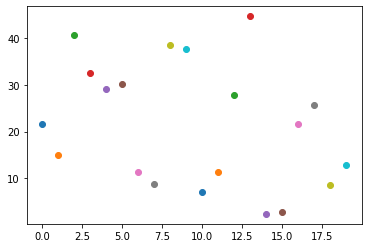

In [288]:
for i in range(20):
    print(ess(s0[..., i, 0]))
    plt.plot(i, ess(s0[..., i, 0]), 'o')

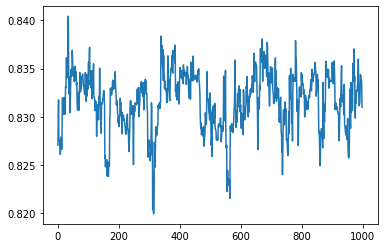

In [298]:
plt.plot(s0[..., 4, -1])

# check data

In [38]:
import loader_hybrid, loader_pk, loader_pk_splits
base_path = "/mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid/"
data_path = '..//data/'
# isim = lh

In [27]:
isim = lh

cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond/"
cfg_path = f"{base_path}/{cfgfolder}/"
print("\nloading sweep")
sweepdict = sbitools.setup_sweepdict(cfg_path)
cfg = sweepdict['cfg']

# setup large scale data and likelihood
print("\nSetting up large scale data")
pk = np.load(f'{data_path}/pkmatter_quijote.npy')[isim, :, 1]
k =  np.load(f'{data_path}/kmatter_quijote.npy')
idx = (k > cfg.kmin) & (k < cfg.ksplit)
klarge, pk_large_data = k[idx], pk[idx]
cov = np.load(f'{data_path}/cov_disconnected_cs1_quijote.npy')[1:klarge.size+1, 1] #1st row is k=0

# setup conditioning for small scales
kcond, pk_cond, _ = loader_hybrid.pkcond(cfg)
pk_cond = pk_cond[isim]

# setup small scales
idx = (k > cfg.ksplit) & (k < cfg.kmax)
ksmall, pk_small = k[idx], pk[idx]
if sweepdict['scaler'] is not None:
    pk_small_data = sbitools.standardize(pk_small.reshape(1, -1).copy(), scaler=sweepdict['scaler'], log_transform=cfg.logit)[0]
    pk_small_data = pk_small_data[0] #remove batch
    
_, pk_small_data_train, _ = loader_hybrid.lh_features(cfg)   ### ERROR : THIS CAN BE WRONG FOR SPLIT > 1
# if sweepdict['scaler'] is not None:
#     pk_small_data_train = sbitools.standardize(pk_small_data_train[isim].reshape(1, -1).copy(), scaler=sweepdict['scaler'], log_transform=cfg.logit)[0]
#     pk_small_data_train = pk_small_data_train[0] #remove batch



loading sweep
In directory /mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid//kmax0.5-kmin0.001-ksplit0.15-nsubs1-splits1-standardize-standardize_cond//
Sweep found : 35qj0ifm

Setting up large scale data
Loaded power spectrum conditioning data with shape :  (2000, 127, 2)
pk shape after k-cuts :  (2000, 23)
Loaded power spectrum data with shape :  (2000, 1, 128)
pk shape after k-cuts :  (2000, 1, 56)


In [28]:

# cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/"
cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/"
cfg_path = f"{base_path}/{cfgfolder}/"

print("\nloading sweep")
sweepdict = sbitools.setup_sweepdict(cfg_path)
cfg = sweepdict['cfg']

# setup large scale data and likelihood
print("\nSetting up large scale data")
pk2 = np.load(f'{data_path}/pkmatter_quijote.npy')[isim, :, 1]
k =  np.load(f'{data_path}/kmatter_quijote.npy')
idx = (k > cfg.kmin) & (k < cfg.ksplit)
klarge2, pk_large_data2 = k[idx], pk2[idx]

# setup conditioning for small scales
kcond2, pk_cond2, _ = loader_hybrid.pkcond(cfg)
pk_cond2 = pk_cond2[isim]

# setup small scales
idx = (k > cfg.ksplit) & (k < cfg.kmax)
ksmall, pk_small = k[idx], pk2[idx]
# if sweepdict['scaler'] is not None:
#     pk_small_data2 = sbitools.standardize(pk_small2.reshape(1, -1).copy(), scaler=sweepdict['scaler'], log_transform=cfg.logit)[0]
#     pk_small_data2 = pk_small_data2[0] #remove batch
    
# _, pk_small_data2_train, _ = loader.lh_features(cfg)   ### ERROR : THIS CAN BE WRONG FOR SPLIT > 1
# if sweepdict['scaler'] is not None:
#     pk_small_data2_train = sbitools.standardize(pk_small_data2_train[isim].reshape(1, -1).copy(), scaler=sweepdict['scaler'], log_transform=cfg.logit)[0]
#     pk_small_data2_train = pk_small_data2_train[0] #remove batch
    

ksmall_sub, pk_small_sub, _ = loader_hybrid.lh_features(cfg)
pk_small_sub = pk_small_sub[isim]

ksmall2, pk_small2, _ = loader_pk.lh_features(cfg)
pk_small2 = pk_small2[isim]
idx = (ksmall2 > cfg.ksplit) & (ksmall2 < cfg.kmax)
ksmall2, pk_small2 = ksmall2[idx], pk_small2[idx]



loading sweep
In directory /mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid//kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp//
Sweep found : f9de89jo

Setting up large scale data
Loaded power spectrum conditioning data with shape :  (2000, 127, 2)
pk shape after k-cuts :  (2000, 23)
Loaded power spectrum data with shape :  (2000, 1, 128)
pk shape after k-cuts :  (2000, 1, 56)
'Objectify' object has no attribute 'dk'
Loaded power spectrum data with shape :  (2000, 128)
pk shape after k-cuts :  (2000, 79)


In [29]:
pk_large_data/ pk_large_data2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [31]:
pk_small/ pk_small2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [37]:
pk_small_sub/ pk_small2

array([[0.9747172 , 1.00855098, 0.97998201, 0.99992989, 1.0100101 ,
        0.98985361, 1.01830398, 0.9970064 , 0.98195076, 1.00636036,
        1.00734551, 0.99392055, 0.99413913, 0.99302856, 1.00958548,
        0.99133533, 1.0035213 , 0.98738697, 0.999118  , 0.98837832,
        1.00184613, 1.00135305, 0.99477241, 0.98438083, 1.00989895,
        1.00217946, 1.00825974, 0.99082888, 0.99870359, 0.98431258,
        0.99122135, 0.99779423, 1.00328412, 0.98601161, 1.00000694,
        0.99529104, 0.99865323, 1.00063715, 1.00722471, 0.9951007 ,
        1.00061634, 0.99283091, 0.98957836, 0.99705026, 0.99341518,
        1.00756042, 0.99338348, 1.00976837, 0.99350235, 0.99836627,
        0.98904461, 0.99897617, 1.00442406, 1.00627094, 1.00658424,
        0.98903219]])

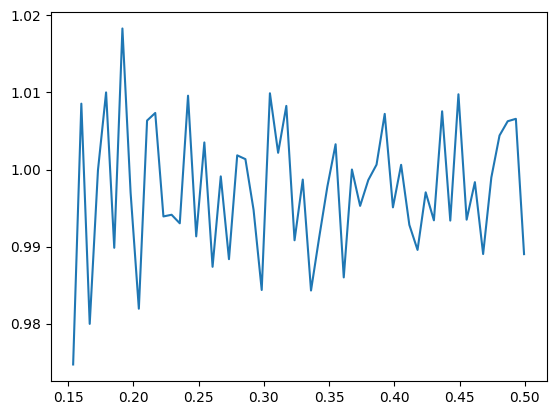

In [45]:
plt.plot(ksmall, pk_small_sub[0]/ pk_small2)

In [36]:
ksmall/ ksmall_sub

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

# comparing mean of sub-boxes

In [640]:
splits = 2
nsubs =  splits**3 
pk = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/power.npy')
# f = np.load(f'/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/power_split{splits}.npy')
# fk = np.load(f"/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split{splits}.npy")
f = np.load(f'/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/power_split{splits}-deconv-interp.npy')
fk = np.load(f"/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split{splits}-deconv-interp.npy")
f.shape
idx = np.random.choice(np.arange(splits**3), nsubs, replace=False)
idx

array([3, 7, 0, 6, 2, 1, 5, 4])

In [26]:
pk.shape

(2000, 128, 2)

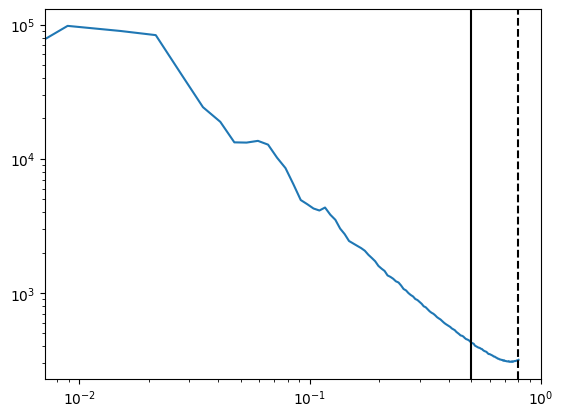

In [643]:
i = 0 
# plt.plot(fk, f[i][idx].mean(axis=0))
plt.plot(pk[i, :, 0], (pk[i, :, 1]))
plt.loglog()
plt.axvline(0.5, color='k')
plt.axvline(0.8, color='k', ls='--')

172


/tmp/ipykernel_551412/3357094863.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(fk, f[i][idx].mean(axis=0)/np.interp(fk, pk[i, :, 0], (pk[i, :, 1])))
/tmp/ipykernel_551412/3357094863.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(fk, f[i][idx].mean(axis=0)/np.exp(np.interp(np.log(fk), np.log(pk[i, :, 0]), np.log(pk[i, :, 1]))))
/tmp/ipykernel_551412/3357094863.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(fk, f[i][idx].mean(axis=0)/np.exp(np.interp(np.log(fk), np.log(pk[i, :, 0]), np.log(pk[i, :, 1]))))


array([0.4507 , 0.03651, 0.5915 , 0.9251 , 0.8981 ])

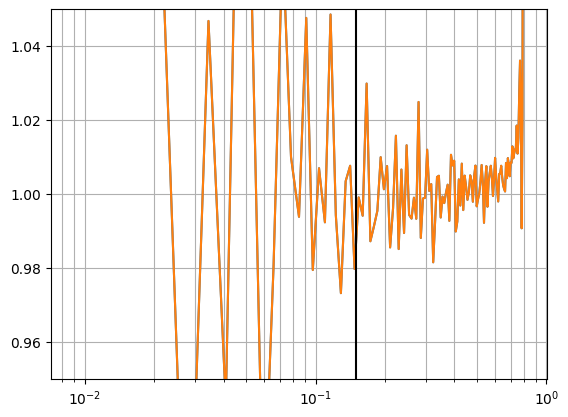

In [644]:
i = np.random.randint(2000)
print(i)
# i = 1877
plt.plot(fk, f[i][idx].mean(axis=0)/np.interp(fk, pk[i, :, 0], (pk[i, :, 1])))
plt.plot(fk, f[i][idx].mean(axis=0)/np.exp(np.interp(np.log(fk), np.log(pk[i, :, 0]), np.log(pk[i, :, 1]))))
plt.semilogx()
plt.ylim(0.95, 1.05)
plt.grid(which='both')
# plt.xlim(0.1, 1)
plt.axvline(0.15, color='k')
params[i]

i = 1877


In [335]:
pkinterp = np.array(list(map(lambda x: np.interp(fk, pk[0, :, 0], x), pk[:, :, 1])))

In [336]:
np.where(fk>0.15)


(array([ 22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
         35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125]),)

[0.1115  0.05263 0.8965  1.0259  0.8859 ]


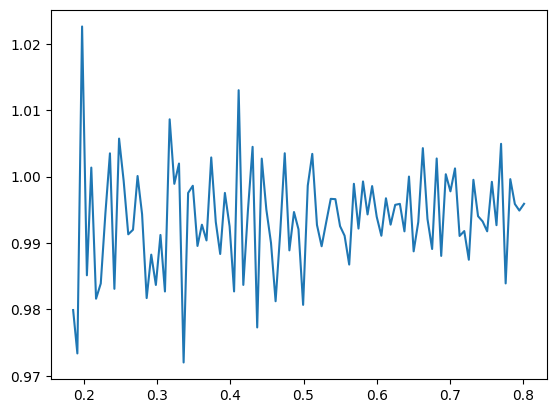

In [277]:
# i = 1516
print(params[i])
ikmin = 27
plt.plot(fk[ikmin:], (f.mean(axis=1)/pkinterp)[i, ikmin:])

In [337]:
params[np.where((f.mean(axis=1)/pkinterp)[:,-1] < 0.98)[0]]

array([[0.1029 , 0.06613, 0.7767 , 1.0115 , 0.6411 ],
       [0.1111 , 0.05339, 0.5243 , 1.0223 , 0.8613 ],
       [0.1035 , 0.06023, 0.5969 , 0.9749 , 0.8885 ],
       [0.1207 , 0.05815, 0.7469 , 0.9779 , 0.8785 ],
       [0.1089 , 0.06127, 0.5655 , 1.1015 , 0.9115 ],
       [0.1009 , 0.04755, 0.6763 , 0.8299 , 0.7825 ],
       [0.1047 , 0.06531, 0.5821 , 0.9449 , 0.9111 ],
       [0.1033 , 0.06631, 0.7563 , 0.8381 , 0.8577 ],
       [0.1195 , 0.06809, 0.6623 , 0.8389 , 0.9899 ],
       [0.1201 , 0.06839, 0.7747 , 1.1719 , 0.9819 ],
       [0.1063 , 0.05781, 0.5083 , 0.9161 , 0.6795 ],
       [0.1113 , 0.06585, 0.5333 , 0.8185 , 0.7385 ],
       [0.1141 , 0.03933, 0.5765 , 0.8837 , 0.9689 ],
       [0.1199 , 0.06617, 0.5037 , 0.8071 , 0.7605 ],
       [0.1059 , 0.06451, 0.6701 , 0.8607 , 0.7123 ],
       [0.1151 , 0.05043, 0.5445 , 0.8281 , 0.6709 ],
       [0.1239 , 0.06043, 0.8123 , 0.8999 , 0.8217 ],
       [0.1021 , 0.06437, 0.5587 , 0.9095 , 0.6857 ],
       [0.1077 , 0.04397, 0.

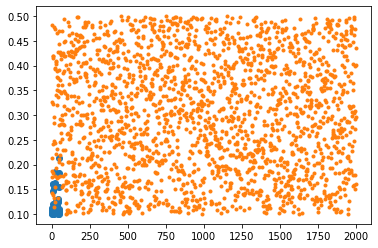

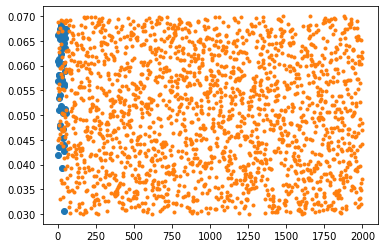

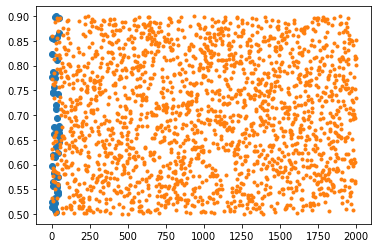

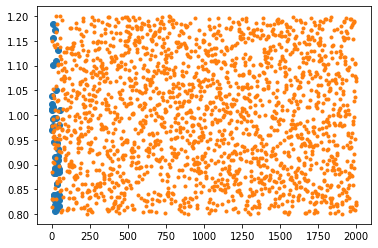

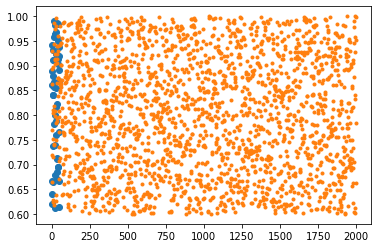

In [338]:
for j in range(5):
    plt.plot(params[np.where((f.mean(axis=1)/pkinterp)[:,-1] < 0.985)[0]][:, j], 'o')
    plt.plot(params[:, j], '.')
    plt.show()

In [342]:
params[params[:, 0] > 0.15].shape

(1750, 5)

In [ ]:
np.where((f.mean(axis=1)/pkinterp)[:,-1] < 0.98)

# SNPE with sub-boxes

In [239]:

# cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/"
# cfgfolder2 = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/"
cfgfolder2 = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/"
cfg_path2 = f"{base_path}/{cfgfolder2}/"

sweepdict2 = sbitools.setup_sweepdict(cfg_path2)
cfg2 = sweepdict2['cfg']
   
# ksmall_sub, features, params = loader_hybrid.lh_features(cfg)
ksmall2, kcond2, features2, params2 = loader_hybrid.loader(cfg2, return_k=True)
print("features shape : ", features.shape)
features2 = features2[:, 0, :]
trainx2, scaler2 = sbitools.standardize(features2, secondary=None, log_transform=cfg2.logit)
trainy2 = params2[:, 0, :5].copy()


In directory /mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid//kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond//
Sweep found : jb6mldl6
Exception in _parse_pk_args:  'Objectify' object has no attribute 'style'
Loaded power spectrum data with shape :  (2000, 1, 126)
pk shape after k-cuts :  (2000, 1, 56)
Loaded power spectrum conditioning data with shape :  (2000, 127, 2)
pk shape after k-cuts :  (2000, 23)
features shape :  (2000, 56)


In [290]:

# cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/"
cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/"
# cfgfolder = "kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond/"
cfg_path = f"{base_path}/{cfgfolder}/"

print("\nloading sweep")
sweepdict = sbitools.setup_sweepdict(cfg_path)
cfg = sweepdict['cfg']
   
# ksmall_sub, features, params = loader_hybrid.lh_features(cfg)
ksmall, kcond, features, params_cond = loader_hybrid.loader(cfg, return_k=True)
print("features shape : ", features.shape)
features = features[:, 0, :]
trainx, scaler = sbitools.standardize(features, secondary=None, log_transform=cfg.logit)
params = params_cond[:, 0, :5].copy()
trainy = params.copy()



loading sweep
In directory /mnt/ceph/users/cmodi/HySBI/matter/networks/hybrid//kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp//
Sweep found : f9de89jo
Loaded power spectrum data with shape :  (2000, 1, 128)
pk shape after k-cuts :  (2000, 1, 56)
Loaded power spectrum conditioning data with shape :  (2000, 127, 2)
pk shape after k-cuts :  (2000, 23)
features shape :  (2000, 1, 56)


In [241]:
### SBI
# trainx, scaler = sbitools.standardize(features, secondary=None, log_transform=True)
# trainy = params.copy()
# prior = sbitools.sbi_prior(trainy.reshape(-1, trainy.shape[-1]), offset=0.2)
prior = sbitools.sbi_prior(trainy.copy(), offset=0.2)
posterior, inference, summary = sbitools.sbi(trainx, trainy, prior, \
                                            summarize=True,
                                            verbose=True, 
                                             nlayers=8, alg='snpe')

Training a new NF
With algorithm SNPE
 Neural network successfully converged after 183 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 183
        Best validation performance: 12.1646
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

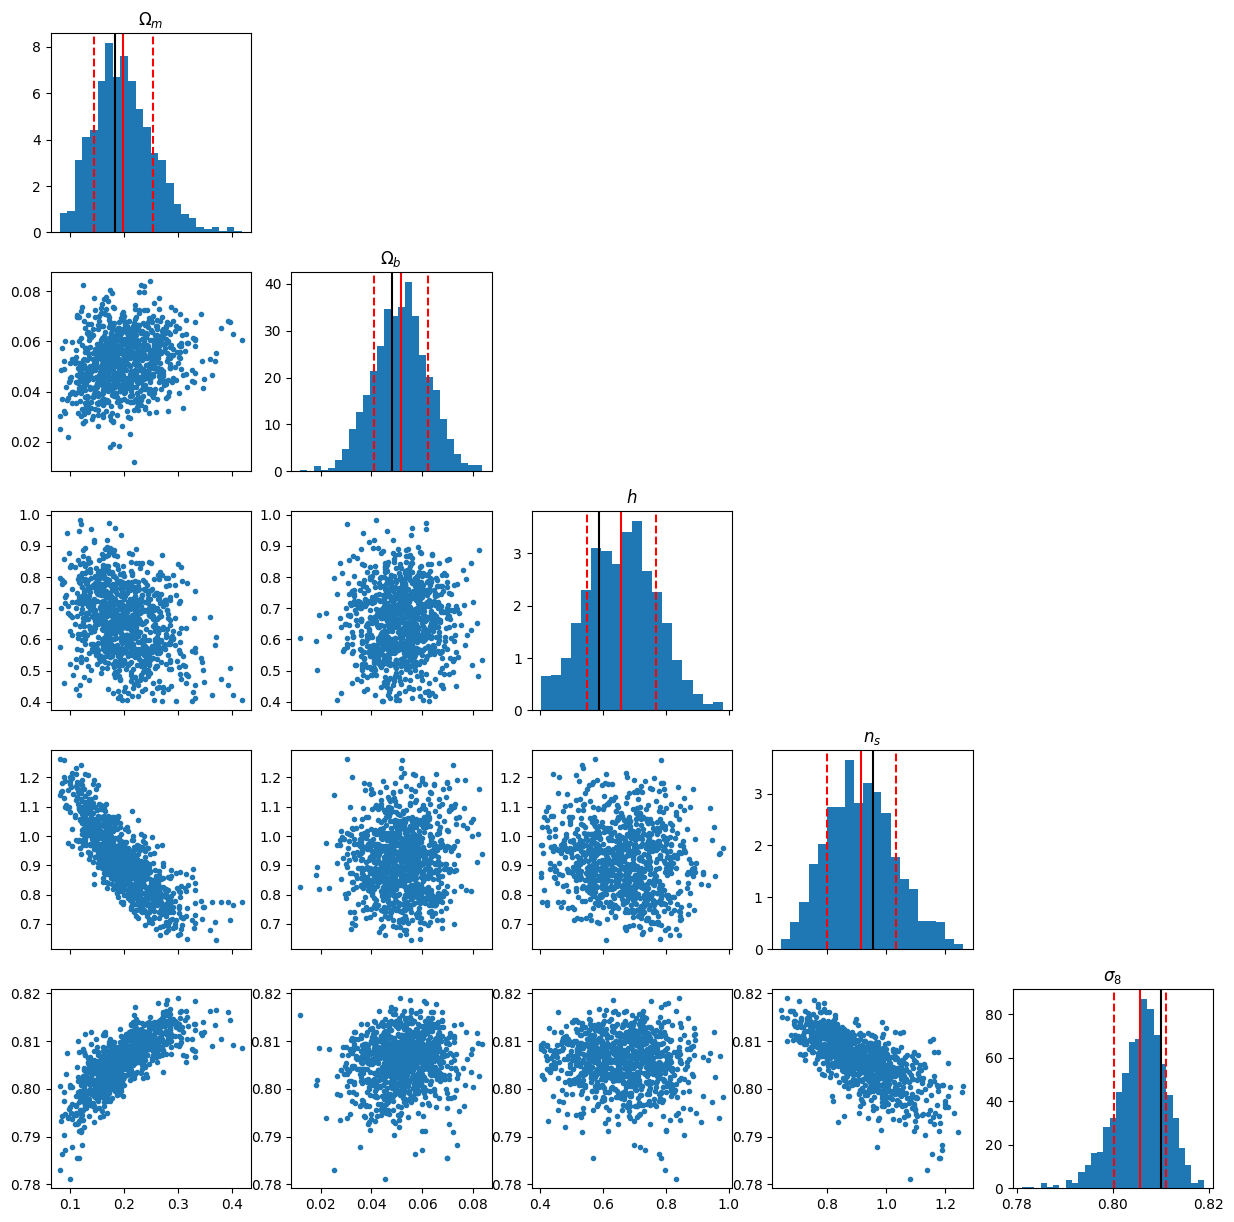

In [242]:
i = 10
fig, ax = sbiplots.plot_posterior(trainx[i], trainy[i], posterior)

In [243]:
nsims, nsamples = 100, 1000
samples = np.zeros([nsims, nsamples, trainy.shape[1]])
for j in range(100):
    x = trainx[j].copy()
    samples[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()

    

<ErrorbarContainer object of 3 artists>

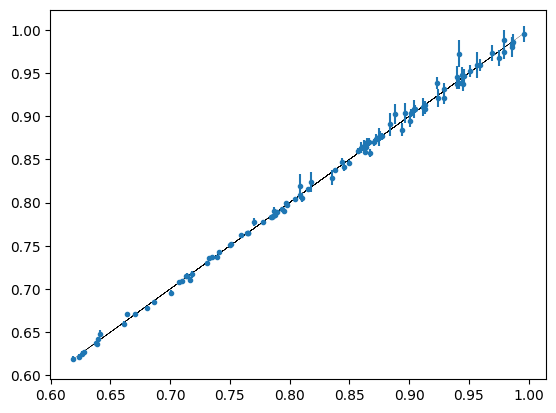

In [244]:
j = 4
plt.plot(trainy[:nsims, j], trainy[:nsims, j], 'k', lw=0.1)
plt.errorbar(trainy[:nsims, j], samples.mean(axis=1)[:, j], samples.std(axis=1)[:, j], fmt='.')


## Check with true data

In [245]:
# setup large scale data and likelihood
print("\nSetting up large scale data")
# pk = np.load(f'{data_path}/pkmatter_quijote.npy')[..., 1]
# k =  np.load(f'{data_path}/kmatter_quijote.npy')

ksmalld, pk_smalld, _ = loader_pk.lh_features(cfg)
# pk_small = pk_small[isim]
idx = (ksmalld > cfg.ksplit) & (ksmalld < cfg.kmax)
ksmalld, pk_smalld = ksmalld[idx], pk_smalld[:, idx]

pk_small_data = sbitools.standardize(pk_smalld.copy(), scaler=scaler, log_transform=cfg.logit)[0]



Setting up large scale data
'Objectify' object has no attribute 'dk'
Loaded power spectrum data with shape :  (2000, 128)
pk shape after k-cuts :  (2000, 79)


In [246]:
pk_small_data.shape

(2000, 56)

In [247]:
nsims, nsamples = 200, 2000
samples = np.zeros([nsims, nsamples, trainy.shape[1]])
samples2 = np.zeros([nsims, nsamples, trainy.shape[1]])
for j in range(nsims):
    x = trainx[j].copy()
    samples[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()
    x = pk_small_data[j].copy()
    samples2[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()

    

<ErrorbarContainer object of 3 artists>

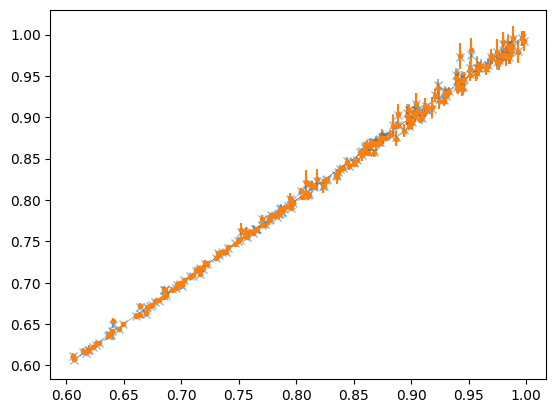

In [248]:
j = 4
plt.plot(trainy[:nsims, j], trainy[:nsims, j], 'k', lw=0.1)
plt.errorbar(trainy[:nsims, j], samples.mean(axis=1)[:, j], samples.std(axis=1)[:, j], fmt='x', alpha=0.5)
plt.errorbar(trainy[:nsims, j], samples2.mean(axis=1)[:, j], samples2.std(axis=1)[:, j], fmt='.')


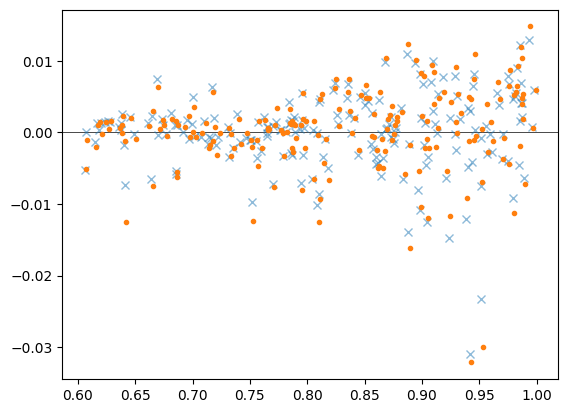

In [249]:
j = 4
# plt.plot(trainy[:nsims, j], trainy[:nsims, j], 'k', lw=0.1)
plt.errorbar(trainy[:nsims, j], trainy[:nsims, j]-samples.mean(axis=1)[:, j], samples.std(axis=1)[:, j]*0, fmt='x', alpha=0.5)
plt.errorbar(trainy[:nsims, j]+0.001, trainy[:nsims, j]-samples2.mean(axis=1)[:, j], samples2.std(axis=1)[:, j]*0, fmt='.')
# plt.errorbar(trainy[:nsims, j], trainy[:nsims, j]-samples.mean(axis=1)[:, j], samples.std(axis=1)[:, j], fmt='x', alpha=0.5)
# plt.errorbar(trainy[:nsims, j]+0.001, trainy[:nsims, j]-samples2.mean(axis=1)[:, j], samples2.std(axis=1)[:, j], fmt='.')
plt.axhline(0, color='k', lw=0.5)

(array([ 6., 18., 35., 41., 23., 24., 25., 18.,  8.,  2.]),
 array([-0.1182052 , -0.08790081, -0.05759643, -0.02729204,  0.00301235,
         0.03331674,  0.06362113,  0.09392552,  0.12422991,  0.1545343 ,
         0.18483869]),
 <BarContainer object of 10 artists>)

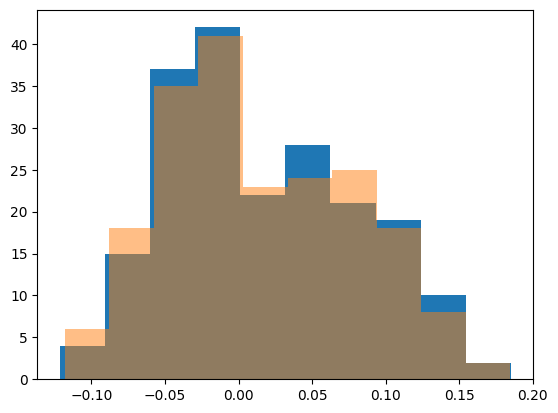

In [250]:
j = 0 
plt.hist(trainy[:nsims, j]-samples2.mean(axis=1)[:, j])
plt.hist(trainy[:nsims, j]-samples.mean(axis=1)[:, j], alpha=0.5)

82


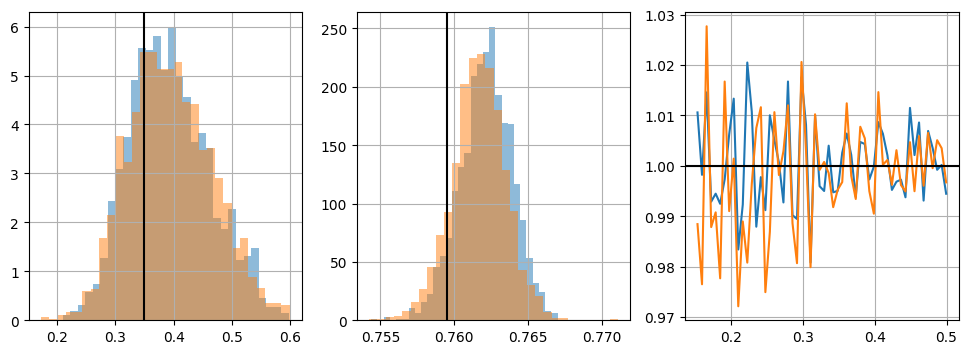

In [251]:
isim = np.random.randint(nsims)
print(isim)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
j = 0
ax[0].hist(samples[isim, :, j], alpha=0.5, bins=30, density=True)
ax[0].hist(samples2[isim, :, j], alpha=0.5, bins=30, density=True);
ax[0].axvline(trainy[isim, j], color='k')

j = 4
ax[1].hist(samples[isim, :, j], alpha=0.5, bins=30, density=True)
ax[1].hist(samples2[isim, :, j], alpha=0.5, bins=30, density=True);
ax[1].axvline(trainy[isim, j], color='k')

ax[2].plot(ksmalld, features[isim]/pk_smalld[isim])
ax[2].plot(ksmalld, features2[isim]/pk_smalld[isim])
ax[2].axhline(1, color='k')
for axis in ax:
    axis.grid(which='both')
plt.show()

# SNLE with sub-box data

In [253]:
trainx.shape, trainy.shape

((2000, 56), (2000, 5))

In [254]:
density_estimator_build_fun = likelihood_nn(model='maf', \
                                           hidden_features=32, \
                                           num_transforms=8,
                                           num_blocks=2)

inference = SNLE_A(prior=prior, density_estimator=density_estimator_build_fun, device='cpu')
inference.append_simulations(x= torch.from_numpy(trainx.astype('float32')), 
                            theta= torch.from_numpy(trainy.astype('float32')))

density_estimator = inference.train(training_batch_size=16,
                                        validation_fraction=0.1,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

posterior_nle = inference.build_posterior(density_estimator)



 Neural network successfully converged after 271 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 271
        Best validation performance: 178.7254
        -------------------------
        


In [ ]:
prior_cond = 
density_estimator_build_fun = likelihood_nn(model='maf', \
                                           hidden_features=32, \
                                           num_transforms=8,
                                           num_blocks=2)

inference = SNLE_A(prior=prior, density_estimator=density_estimator_build_fun, device='cpu')
inference.append_simulations(x= torch.from_numpy(trainx.astype('float32')), 
                            theta= torch.from_numpy(trainy.astype('float32')))

density_estimator = inference.train(training_batch_size=16,
                                        validation_fraction=0.1,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

posterior_nle = inference.build_posterior(density_estimator)



In [266]:
prior.sample()

tensor([0.5365, 0.0136, 0.5857, 1.0171, 0.6072])

In [267]:
j = 0 
nsamples = 500 
x = trainx[j].copy()
print(x.shape)
samples_nle = posterior_nle.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=True).detach().numpy()


(56,)


Tuning bracket width...: 100%|██████████| 50/50 [00:03<00:00, 15.96it/s]

Generating samples: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]

Running 1 MCMC chains in 1 batches.: 100%|██████████| 1/1 [04:22<00:00, 262.04s/it]


In [268]:
# x = trainx[j].copy()
x = pk_small_data[j].copy()
print(x.shape)
samples_nle2 = posterior_nle.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=True).detach().numpy()


(56,)


Tuning bracket width...: 100%|██████████| 50/50 [00:03<00:00, 15.20it/s]

Generating samples: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

Running 1 MCMC chains in 1 batches.: 100%|██████████| 1/1 [04:12<00:00, 252.30s/it]


(array([ 32.,  53., 103., 114.,  80.,  65.,  33.,  13.,   3.,   4.]),
 array([0.08061912, 0.09748184, 0.11434455, 0.13120727, 0.14806999,
        0.16493271, 0.18179543, 0.19865814, 0.21552086, 0.23238358,
        0.2492463 ]),
 <BarContainer object of 10 artists>)

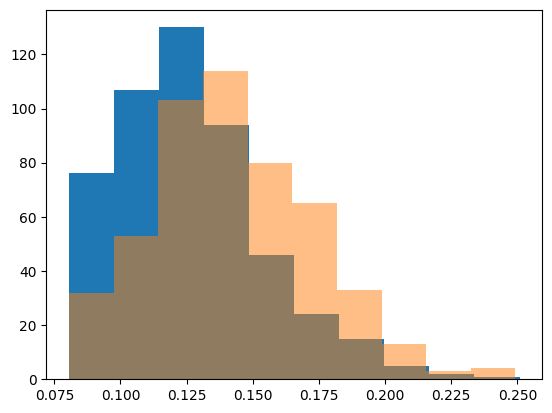

In [272]:
plt.hist(samples_nle[:, 0])
plt.hist(samples_nle2[:, 0], alpha=0.5)


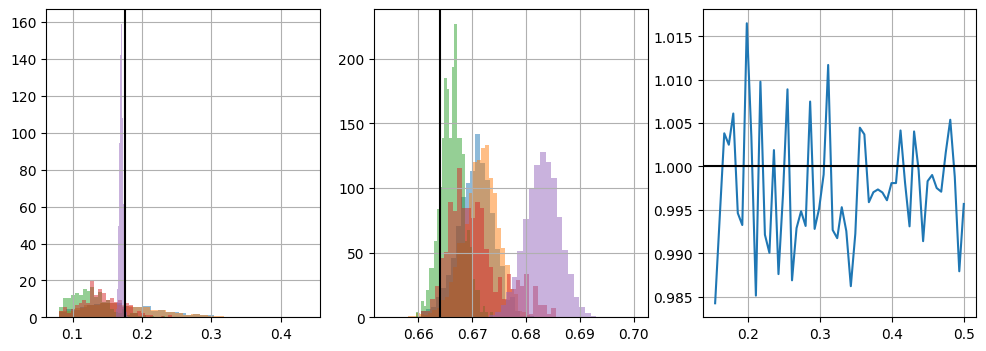

In [291]:
# isim = np.random.randint(nsims)
# print(isim)
isim = 0 
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
j = 0
ax[0].hist(samples[isim, :, j], alpha=0.5, bins=30, density=True)
ax[0].hist(samples2[isim, :, j], alpha=0.5, bins=30, density=True);
ax[0].hist(samples_nle[:, j], alpha=0.5, bins=30, density=True);
ax[0].hist(samples_nle2[ :, j], alpha=0.5, bins=30, density=True);
ax[0].hist(ss[..., j].flatten(), alpha=0.5, bins=30, density=True)
ax[0].axvline(trainy[isim, j], color='k')

j = 4
ax[1].hist(samples[isim, :, j], alpha=0.5, bins=30, density=True)
ax[1].hist(samples2[isim, :, j], alpha=0.5, bins=30, density=True);
ax[1].axvline(trainy[isim, j], color='k')
ax[1].hist(samples_nle[:, j], alpha=0.5, bins=30, density=True);
ax[1].hist(samples_nle2[:, j], alpha=0.5, bins=30, density=True);
ax[1].hist(ss[..., j].flatten(), alpha=0.5, bins=30, density=True)

ax[2].plot(ksmalld, features[isim]/pk_smalld[isim])
# ax[2].plot(ksmalld, features2[isim]/pk_smalld[isim])
ax[2].axhline(1, color='k')
for axis in ax:
    axis.grid(which='both')
plt.show()

In [278]:
ss = np.load("/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2/kmax0.5-kmin0.001-ksplit0.15-meanf-nsubs8-splits2-standardize-standardize_cond-style-deconv-interp/ens10/LH0.npy")

(array([  36.,  383., 1995., 4814., 6195., 4389., 1731.,  375.,   69.,
          13.]),
 array([0.16127062, 0.16327346, 0.16527631, 0.16727915, 0.16928199,
        0.17128483, 0.17328767, 0.17529051, 0.17729335, 0.17929619,
        0.18129903]),
 <BarContainer object of 10 artists>)

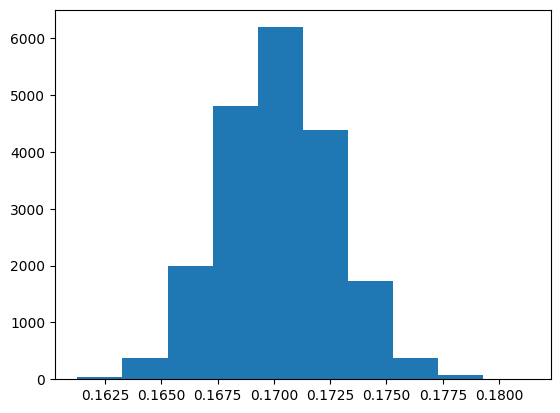

In [497]:
s1 = np.load('/mnt/ceph/users/cmodi/HySBI/matter/samples/PT/kmax0.15/LH1068_backup.npy')
s2 = np.load('/mnt/ceph/users/cmodi/HySBI/matter/samples/PT/kmax0.15/LH1068.npy')
s3 = np.load('/mnt/ceph/users/cmodi/HySBI/matter/samples/PT_varycov/kmax0.15/LH1068.npy')


In [498]:
s1.shape, s2.shape

((1000, 20, 6), (1000, 20, 6))

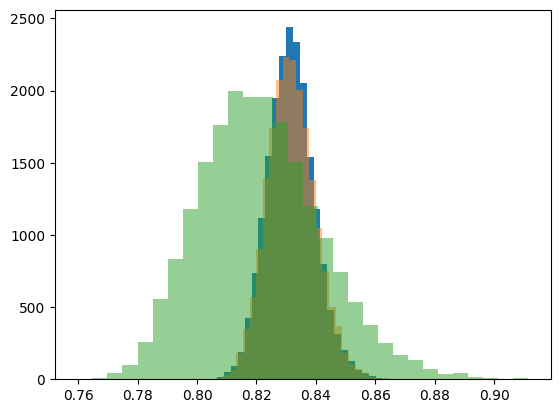

In [504]:
i = 4
plt.hist(s1[..., i].flatten(), bins=30);
plt.hist(s2[..., i].flatten(), bins=30, alpha=0.5);
plt.hist(s3[..., i].flatten(), bins=30, alpha=0.5);

In [61]:
testidx.size

300

1068


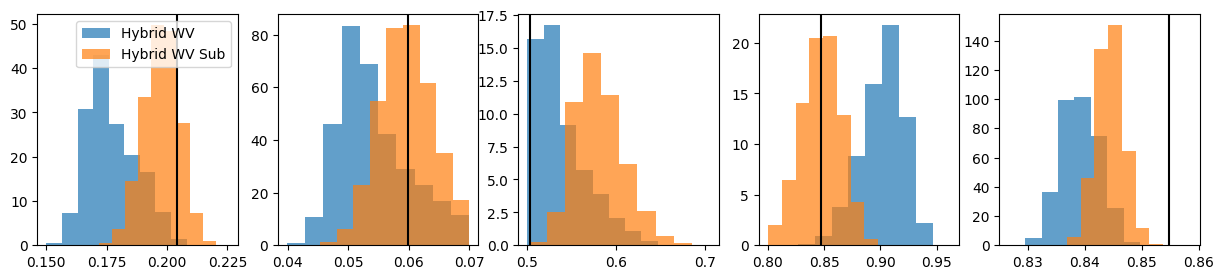

In [137]:

lh = testidx[0]
print(lh)
ss0 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/kmax0.5-kmin0.001-logit-standardize//ens10/LH{lh}.npy')
ss1 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/J7-M4-Q3-kc0.67-logit-standardize/ens10/LH{lh}.npy')
ss2 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_wv/J3-M4-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10_varycov/LH{lh}.npy')
ss3 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid2_wv_sub/J3-M4-Q4-e0.1-kc0.67-kmin0.001-ksplit0.15-logit-meanf-nsubs8-splits2-standardize-standardize_cond/ens10_varycov/LH{lh}.npy')


fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    # ax[i].hist(ss0[..., i].flatten(), alpha=0.7, density=True, label='SNLE PS')
    # ax[i].hist(ss1[..., i].flatten(), alpha=0.7, density=True, label='SNLE WV')
    ax[i].hist(ss2[..., i].flatten(), alpha=0.7, density=True, label='Hybrid WV')
    ax[i].hist(ss3[..., i].flatten(), alpha=0.7, density=True, label='Hybrid WV Sub')
    ax[i].axvline(params[lh, i], color='k')

ax[0].legend()
plt.show()

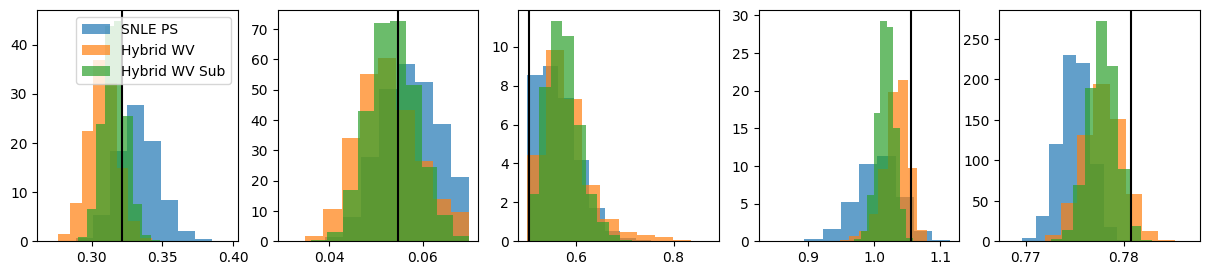

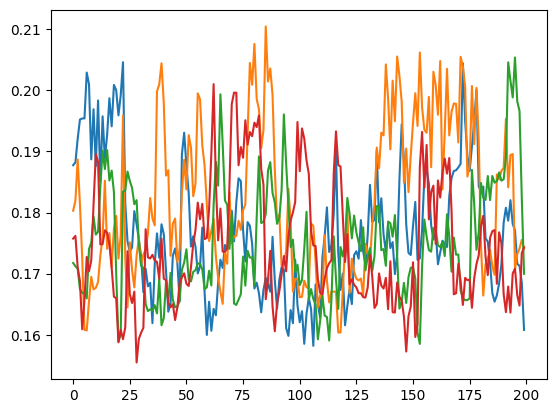

In [123]:
plt.plot(ss2[:200, ::5, 0])

In [121]:
for i in range(6):
    esschain = np.array(list(map(ess, ss2[..., i].T)))
    print(i, esschain.min(), esschain.max())

0 58.59130235733205 116.67634689156029
1 58.080748377776175 117.29096347965223
2 60.0238875209613 111.9669614598289
3 61.85659645812896 131.28592010168998
4 66.45324708163515 126.37904450689888
5 40.84578457276416 145.92607358285372


In [118]:
for i in range(6):
    print(1000/np.array(list(map(ess, ss2[..., i].T))))

[11.18764168  8.57071743 11.34741575  9.23526566  9.96070259 17.06737962
 14.36667139 10.59616908 15.3633419  11.39706241 13.14596545 15.17814335
 10.51731569 13.55577848  9.39636675 11.21415284 11.34882361  8.69533884
 13.35683056  9.70390683]
[13.94078842  9.58998243  8.525806   11.61925818 12.44016642 16.61913469
 13.14060833 14.41488604  9.82026687  9.7468986  12.63676643 17.217409
 11.63074346 13.69364569 12.58330237 11.05048297 11.92256072  9.13803763
 10.3360073  10.12680912]
[12.58851228 10.43509177  8.93120602 13.12589902 11.22444804 16.66003388
 14.86582719 13.59349588  9.20392658 13.39319604 12.37396263 15.6506379
 13.66792262 14.35507331 11.54147454 10.79888214 12.85850858 11.20892253
  9.45571806  9.68088958]
[ 9.67012881  9.16940984 10.91690006  7.61696303  9.10517021 15.21296552
 14.28695871  8.86964544  9.42415729 13.72757653 12.04376995 11.53886576
 14.14486132  9.36328477 12.26025756 12.82968367 10.04436427  9.63619976
 16.16642456  9.76795755]
[ 8.6914121  13.2325094

In [36]:
s0, s1 = {}, {}
for i in range(nsims):
    isim = testidx[i]
    # isim = goodids[i]

    # if  (0.15 < params[isim, 0] < 0.45) & (0.65 < params[isim, 4] < 0.95) :
    # if  (0.2 < params[isim, 0] < 0.4) & (0.65 < params[isim, 4] < 0.9) :
    try:
        # samples = clean_chains(np.load(run%isim))
        s0[isim] = np.load('/mnt/ceph/users/cmodi/HySBI/matter/samples/snpe/kmax0.5-kmin0.001-logit-standardize/LH%d.npy'%isim)
    except Exception as e:
        print(e)
    try:
        # samples = clean_chains(np.load(run%isim))
        s1[isim] = np.load('/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/kmax0.5-kmin0.001-logit-standardize/ens10/LH%d.npy'%isim)
    except Exception as e:
        continue #print(e)


In [42]:
sstd = []
for k in s0.keys():
    sstd.append([s0[k].std(axis=(0, 1)), s1[k].std(axis=(0, 1))])

In [43]:
sstd = np.array(sstd)

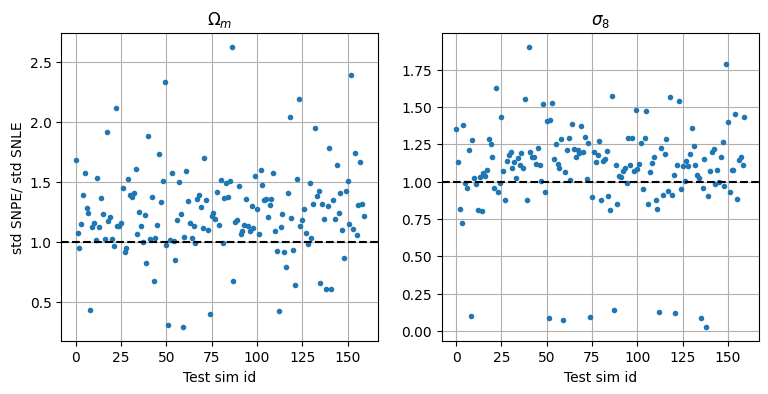

In [65]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plt.plot(sstd[:, 0, 0]/sstd[:, 1, 0], '.')
plt.grid(which='both')
plt.ylabel('std SNPE/ std SNLE')
plt.xlabel('Test sim id')
plt.title('$\Omega_m$')
plt.axhline(1, color='k', ls="--")
plt.subplot(122)
plt.plot(sstd[:, 0, 4]/sstd[:, 1, 4], '.')
plt.grid(which='both')
plt.xlabel('Test sim id')
plt.title('$\sigma_8$')
plt.axhline(1, color='k', ls="--")


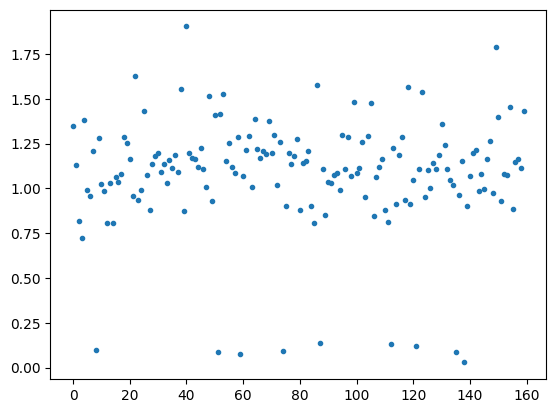

(array([ 6.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  7., 19., 20., 38., 29.,
        15., 10.,  5.,  4.,  1.,  1.,  1.]),
 array([0.02892668, 0.12266744, 0.2164082 , 0.31014896, 0.40388972,
        0.49763048, 0.59137124, 0.685112  , 0.77885276, 0.87259352,
        0.96633428, 1.06007504, 1.1538158 , 1.24755656, 1.34129732,
        1.43503808, 1.52877884, 1.6225196 , 1.71626036, 1.81000112,
        1.90374188]),
 <BarContainer object of 20 artists>)

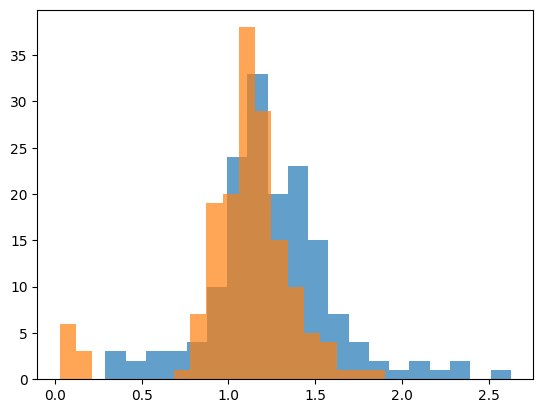

In [53]:
plt.hist(sstd[:, 0, 0]/sstd[:, 1, 0], 20, alpha=0.7)
plt.hist(sstd[:, 0, 4]/sstd[:, 1, 4], 20, alpha=0.7)


In [56]:
((sstd[:, 0, 0]/sstd[:, 1, 0]) > 1).sum(), ((sstd[:, 0, 4]/sstd[:, 1, 4]) > 1).sum()

(133, 117)

# Desi figure

In [1]:
%pylab inline 


Populating the interactive namespace from numpy and matplotlib


In [31]:
desi = [0.6559191530317612, 6.707692307692307,
0.6751684311838306, 7.316923076923077,
0.7059672762271416, 8.166153846153847,
0.7444658325312801, 9.033846153846154,
0.7868142444658324, 7.556923076923077,
0.8214629451395574, 6.633846153846154,
0.8445620789220405, 5.987692307692307,
0.8984600577478343, 4.935384615384615,
0.936958614051973, 3.9753846153846153,
0.9870067372473532, 2.941538461538461,
1.0293551491819055, 1.9630769230769225,
1.1448508180943213, 1.556923076923077,
1.2333974975938402, 1.4646153846153833,
1.3334937439846006, 0.6523076923076907,
1.4720885466794995, 0.4861538461538455,
1.5952839268527428, 0.3199999999999985,
1.6607314725697786, 0.19076923076922903,
1.8031761308950913, 0.1169230769230758,
# 0.7906641000962464, 8.036923076923078,
# 0.7290664100096245, 8.60923076923077,
# 0.7675649663137631, 8.572307692307692,
# 0.7675649663137631, 8.572307692307692,
# 1.2834456207892202, 1.0769230769230749
]


euclid = [
    0.6491400133101071, 1.1700716253443506,
0.6712994853602081, 1.4347298156389048,
0.6884552056570608, 1.6738219961856302,
0.7056109259539132, 1.9129141767323574,
0.7244345635018488, 2.1744301758847193,
0.7399223665476182, 2.4258054672600107,
0.7763782721784298, 2.602495289834131,
0.8235565029947742, 2.7371161070334606,
0.8707347338111187, 2.734311506675142,
0.9179129646274629, 2.618388025197941,
0.9650911954438073, 2.4865718083569313,
1.0122694262601517, 2.336993122579898,
1.0594476570764961, 2.1892841703750783,
1.1066258878928406, 2.0415752181702587,
1.153804118709185, 1.897605733109863,
1.2009823495255292, 1.770463850199386,
1.2481605803418736, 1.6405173669305881,
1.295338811158218, 1.5068314165173646,
1.3425170419745625, 1.3694059989597154,
1.3896952727909069, 1.2319805814020661,
1.436873503607251, 1.0945551638444186,
1.4840517344235955, 0.9674132809339397,
1.53122996523994, 0.8421411315956746,
1.5784081960562841, 0.7290222504767936,
1.6255864268726286, 0.6205777032884452,
1.672764657688973, 0.5270910246777998,
1.7199428885053174, 0.44108328035600586,
1.7671211193216618, 0.3634893371091703,
1.8142993501380063, 0.298983528867824,
1.8614775809543507, 0.24008692134311893,
1.908655811770695, 0.19053898167947558,
1.9558340425870395, 0.142860775588046,
2.003012273403384, 0.09705230306883017,
2.041612644071302, 0.057654345654343686]


desibgs = [
#     0.6491400133101071, 1.1700716253443506,
# 0.6712994853602081, 1.4347298156389048,
# 0.6884552056570608, 1.6738219961856302,
# 0.7056109259539132, 1.9129141767323574,
# 0.7244345635018488, 2.1744301758847193,
# 0.7399223665476182, 2.4258054672600107,
# 0.7763782721784298, 2.602495289834131,
# 0.8235565029947742, 2.7371161070334606,
# 0.8707347338111187, 2.734311506675142,
# 0.9179129646274629, 2.618388025197941,
# 0.9650911954438073, 2.4865718083569313,
# 1.0122694262601517, 2.336993122579898,
# 1.0594476570764961, 2.1892841703750783,
# 1.1066258878928406, 2.0415752181702587,
# 1.153804118709185, 1.897605733109863,
# 1.2009823495255292, 1.770463850199386,
# 1.2481605803418736, 1.6405173669305881,
# 1.295338811158218, 1.5068314165173646,
# 1.3425170419745625, 1.3694059989597154,
# 1.3896952727909069, 1.2319805814020661,
# 1.436873503607251, 1.0945551638444186,
# 1.4840517344235955, 0.9674132809339397,
# 1.53122996523994, 0.8421411315956746,
# 1.5784081960562841, 0.7290222504767936,
# 1.6255864268726286, 0.6205777032884452,
# 1.672764657688973, 0.5270910246777998,
# 1.7199428885053174, 0.44108328035600586,
# 1.7671211193216618, 0.3634893371091703,
# 1.8142993501380063, 0.298983528867824,
# 1.8614775809543507, 0.2400869213431183,
# 1.908655811770695, 0.19053898167947558,
# 1.9558340425870395, 0.142860775588046,
# 2.003012273403384, 0.09705230306883017,
# 2.041612644071302, 0.057654345654343686,
0.3421559191530318, 9.883076923076924,
0.3402309913378251, 9.624615384615385,
0.34023099133782486, 9.218461538461538,
0.34600577478344563, 8.701538461538462,
0.34793070259865255, 8.24,
0.3498556304138595, 7.723076923076923,
0.35563041385948035, 7.224615384615385,
0.3671799807507219, 6.670769230769231,
0.37295476419634255, 6.172307692307692,
0.3806544754571708, 5.526153846153846,
0.3902791145332051, 4.9169230769230765,
0.3941289701636189, 4.5661538461538465,
0.3979788257940329, 4.030769230769231,
0.40567853705486057, 3.476923076923076,
0.42107795957651595, 2.701538461538461,
0.42877767083734364, 1.9630769230769225,
0.43647738209817133, 1.224615384615383,
0.448026948989413, 0.8184615384615377
          ]



boss =[0.047641963426371614, 4.086153846153845,
0.15543792107795962, 4.178461538461538,
0.24013474494706455, 4.233846153846153,
0.3440808469682387, 4.335384615384615,
0.42877767083734364, 4.39076923076923,
0.5173243503368624, 4.436923076923077,
0.5442733397497594, 4.436923076923077,
0.5596727622714148, 4.030769230769231,
0.5750721847930704, 3.569230769230769,
0.5904716073147256, 3.1076923076923073,
0.6116458132820017, 2.6461538461538465,
0.6251203079884504, 2.24,
0.6424446583253127, 1.833846153846153,
0.6559191530317612, 1.5015384615384608,
0.6328200192492781, 2.0553846153846145,
0.6751684311838306, 1.2523076923076903,
0.7059672762271416, 0.8184615384615377,
0.7271414821944175, 0.5046153846153842,
0.7444658325312801, 0.22769230769230653]


eboss_noelg = [0.5442733397497594, 0.1169230769230758,
0.5731472569778633, 0.615384615384615,
0.6000962463907604, 1.1876923076923074,
0.6289701636188643, 1.7599999999999998,
0.640519730510106, 1.9630769230769225,
0.6636188642925889, 1.7784615384615385,
0.6982675649663139, 1.4092307692307688,
0.7329162656400385, 1.0769230769230749,
0.7444658325312801, 0.9292307692307684,
0.7906641000962464, 0.6892307692307682,
0.850336862367661, 0.46769230769230674,
0.9100096246390761, 0.19076923076922903,
0.9446583253128007, 0.06153846153846132,
1.0178055822906642, 0.1169230769230758,
1.0986525505293552, 0.1169230769230758,
1.2218479307025987, 0.13538461538461455,
1.3527430221366699, 0.1169230769230758,
1.4720885466794995, 0.13538461538461455,
1.6453320500481232, 0.1169230769230758,
1.872473532242541, 0.10769230769230731,
2.138113570741098, 0.09846153846153705,
2.0226179018286814, 0.08000000000000007]


eboss_elg = [0.5519730510105871, 0.1538461538461533,
0.5750721847930704, 0.6707692307692295,
0.6020211742059673, 1.4092307692307688,
0.6212704523580366, 1.7969230769230755,
0.642444658325313, 2.138461538461538,
0.6559191530317612, 2.258461538461537,
0.7021174205967275, 2.2030769230769227,
0.7444658325312801, 2.110769230769229,
0.7791145332050049, 1.9076923076923062,
0.8099133782483157, 1.6123076923076916,
0.8445620789220405, 1.2984615384615381,
0.8888354186717997, 0.9107692307692297,
0.9138594802694899, 0.615384615384615,
0.936958614051973, 0.37538461538461476,
0.9523580365736286, 0.26461538461538403,
0.9908565928777668, 0.22769230769230653,
1.0986525505293552, 0.06153846153846132,
1.0370548604427334, 0.13538461538461455,
1.1987487969201154, 0.04307692307692079,
1.3180943214629453, 0.09846153846153705,
1.422040423484119, 0.09846153846153705,
1.533686236766121, 0.1169230769230758,
1.637632338787295, 0.09846153846153705]

wfirst = [1.703079884504331, 9.938461538461539,
1.7184793070259863, 9.550769230769232,
1.7415784408084698, 9.08923076923077,
1.7685274302213663, 8.516923076923078,
1.7916265640038498, 8.036923076923078,
1.8147256977863329, 7.538461538461538,
1.845524542829644, 7.095384615384615,
1.872473532242541, 6.5600000000000005,
1.8955726660250236, 6.135384615384615,
1.9148219441770928, 5.747692307692308,
1.9263715110683362, 5.507692307692308,
1.9417709335899902, 5.323076923076923,
1.9552454282964389, 4.953846153846153,
1.9610202117420594, 4.603076923076923,
1.9764196342637153, 4.067692307692307,
1.984119345524543, 3.6061538461538456,
1.9975938402309916, 3.144615384615384,
2.0091434071222327, 2.701538461538461,
2.0187680461982676, 2.258461538461537,
2.028392685274302, 1.8892307692307675,
2.036092396535129, 1.5384615384615383,
2.038017324350337, 1.2430769230769219,
2.1111645813282, 1.1692307692307686,
2.2035611164581326, 1.058461538461538,
2.276708373435996, 0.9661538461538459,
2.3652550529355145, 0.8184615384615377,
2.4461020211742057, 0.707692307692307,
2.523099133782483, 0.615384615384615,
2.6231953801732435, 0.4861538461538455,
2.7155919153031762, 0.37538461538461476,
2.7463907603464865, 0.33846153846153726,
         ]

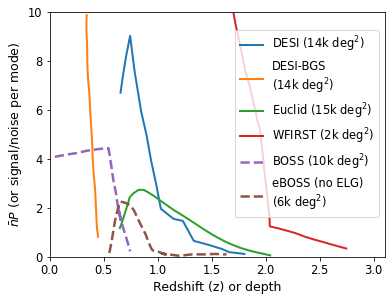

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))

f = np.array(desi).reshape(-1,2)
plt.plot(f[:, 0], f[:, 1], lw=2, label='DESI (14k deg$^2$)')
f = np.array(desibgs).reshape(-1,2)
plt.plot(f[:, 0], f[:, 1], lw=2, label='DESI-BGS\n(14k deg$^2$)')
f = np.array(euclid).reshape(-1,2)
plt.plot(f[:, 0], f[:, 1], lw=2, label='Euclid (15k deg$^2$)')
f = np.array(wfirst).reshape(-1,2)
plt.plot(f[:, 0], f[:, 1], lw=2, label='WFIRST (2k deg$^2$)')
f = np.array(boss).reshape(-1,2)
plt.plot(f[:, 0], f[:, 1], ls="--", lw=2.5, label='BOSS (10k deg$^2$)')
f = np.array(eboss_elg).reshape(-1,2)
# plt.plot(f[:, 0], f[:, 1], ls="--", lw=2.5, label='eBOSS w/ELG (1.5k deg$^2$)')
# f = np.array(eboss_noelg).reshape(-1,2)
plt.plot(f[:, 0], f[:, 1], ls="--", lw=2.5, label='eBOSS (no ELG)\n(6k deg$^2$)')
plt.ylim(0, 10)
plt.xlim(0, 3.1)

axis = plt.gca()
# axis.grid(which='both', lw=0.3)
axis.xaxis.set_tick_params(labelsize=11.5)
axis.yaxis.set_tick_params(labelsize=11.5)
# plt.xlabel('${Redshift\, (z)\, or\,\, depth}$', fontsize=14)
# plt.ylabel(r'${\bar{n}P}\, (or\, signal\,/\,noise\,\, per\,\, mode)$', fontsize=14)
plt.xlabel('Redshift (z) or depth', fontsize=12.5)`
plt.ylabel(r'${\bar{n}P}$ (or signal/noise per mode)', fontsize=12.5)
# plt.legend()
legend = plt.legend(loc="upper right",  fontsize=11.5, ncol=1, bbox_to_anchor=(1.,0.95))
# legend = plt.legend(loc="upper right",  fontsize=12, ncol=1)
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((1, 1, 1, 0.3))
plt.savefig('desivol.pdf')

In [117]:
!pwd

/mnt/home/cmodi/Research/Projects/HySBI/notebooks
